In [2]:
# import libraries
import ibmos2spark
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,size,isnan,isnull,from_unixtime,round,rand,to_date,col,when,date_format,to_timestamp
from pyspark.sql.types import StringType,IntegerType
from pyspark.storagelevel import StorageLevel
from pyspark.ml.feature import  VectorAssembler,StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer, MinMaxScaler,StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

The codes in the next cell are added by the IBM Warson platform.`

In [3]:
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': 'qQcmfJVnM3wKLSy70pfwa1l62aTnZvjc7tMRWqob6mqO',
    'service_id': 'iam-ServiceId-455e4c48-5974-41c0-b4d0-1903bdc2198a',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token'}

configuration_name = 'os_c134bc0d626243e39cc514bae3095301_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-eppedp7n4vmwjv'))
df_data_1.take(2)
users=df_data_1
users.cache()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

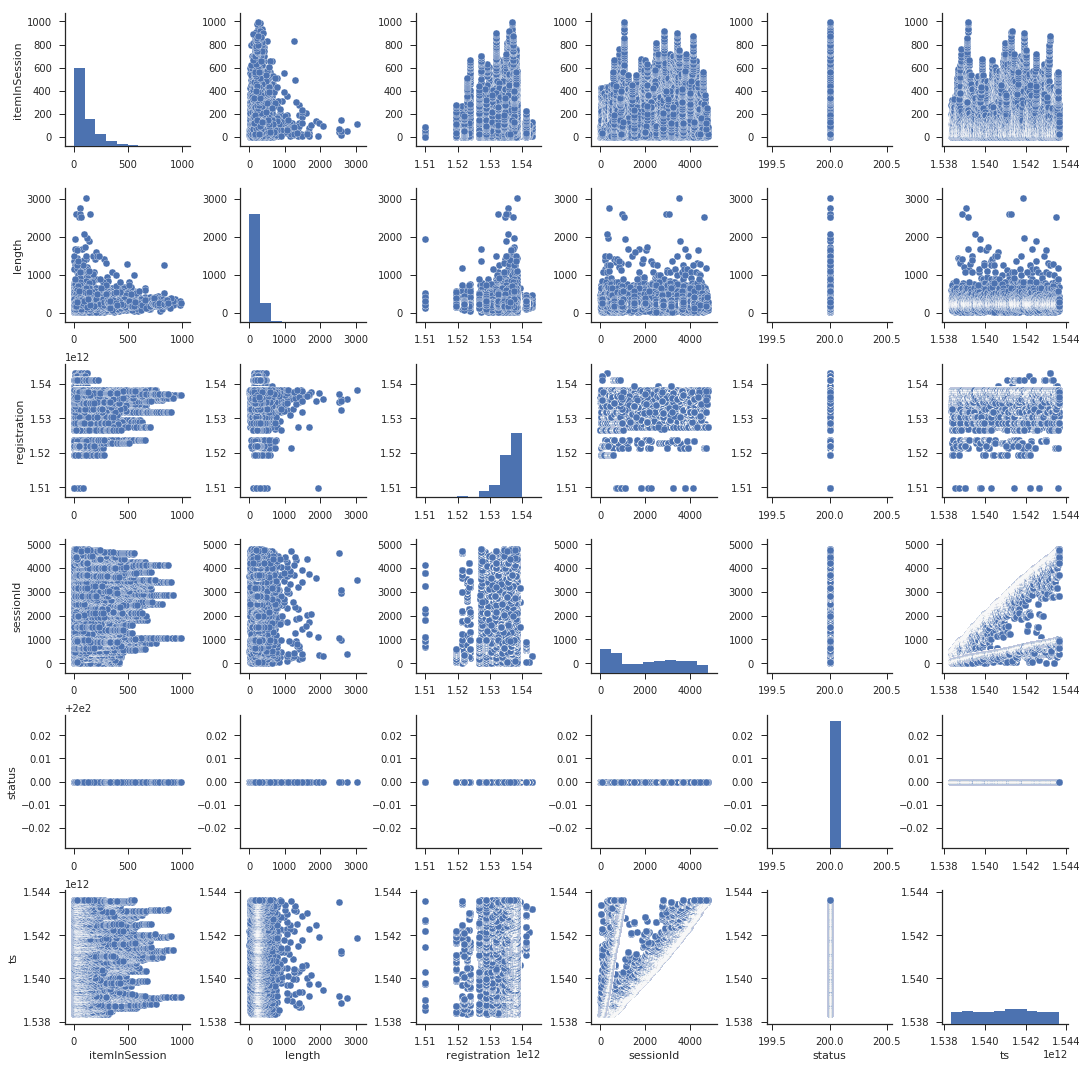

In [4]:

users.createOrReplaceTempView("users")


#use the Pandas library to examine correlations between the numeric columns by generating scatter plots of them.
#For the Pandas workload, we don't want to pull the entire data set into the Spark driver, as that might exhaust the available RAM and throw an out-of-memory exception. 
#Instead, I shall randomly sample a portion of the data (say 10%) to get a rough idea of how it looks.
sampled_data = users.sample(False, 0.10).toPandas()
sampled_data=sampled_data.select_dtypes(include=[np.number])

sns_data=sampled_data.dropna()
# scatter plot
sns.set(style="ticks", color_codes=True)
spp = sns.pairplot(sns_data)

## analysis:
 - "userid" is same as "first name" and "last name". so "first name" and "last name" can be removed.
 - "userAgent" and "method" is rela1ted with tools and is not related with business, it can be removed.
 - "status" has not correlation with others. the figure is a line. so both can be removed.
 - "session id" has high correlation with "ts". the (sessionid,registration) figure is same as (ts,registration) so it can be removed.
 - the others columns will be kept for further analysis.

In [5]:
def assess_page_dist(df, num_full_cols_list,hue="churn"):
    """
    Function description: 
       Assess extream values distribution for columns with no missing value. 
    Input:
        df: Dataframe, dataset 
        num_full_cols_list:numeric columns to be assessed.
    Return:
        NA   
    """
    """
    Function description: 
       Assess extream values distribution for columns with no missing value. 
    Input:
        df: Dataframe, dataset 
        num_full_cols_list:full numeric columns to be assessed.
    Return:
        NA   
    """
    # calculate how many subplots and set figure size 
    count=len(num_full_cols_list)
    base_width=1
    base_high=1
    max_row_figures=8
    if count> max_row_figures:
        width= max_row_figures*base_width
        rows= count//max_row_figures+1
        high = base_high*rows
    else:
        width=2*base_width
        rows=2
        high =base_high

    # set figure styple
    plt.style.use('ggplot')
    # set figure size
    fig_gap=5*rows
    #plt.figure(figsize=(width,high+fig_gap))
    i=1
        
    fig = plt.figure(figsize=(width+fig_gap,high+fig_gap))
    for i in range(1,len(num_full_cols_list)+1):
        ax = fig.add_subplot(rows,max_row_figures,i)  
        df.boxplot(df.columns[i].format(), ax=ax, grid=False, vert=True,  by='Churn', showfliers=False);


+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



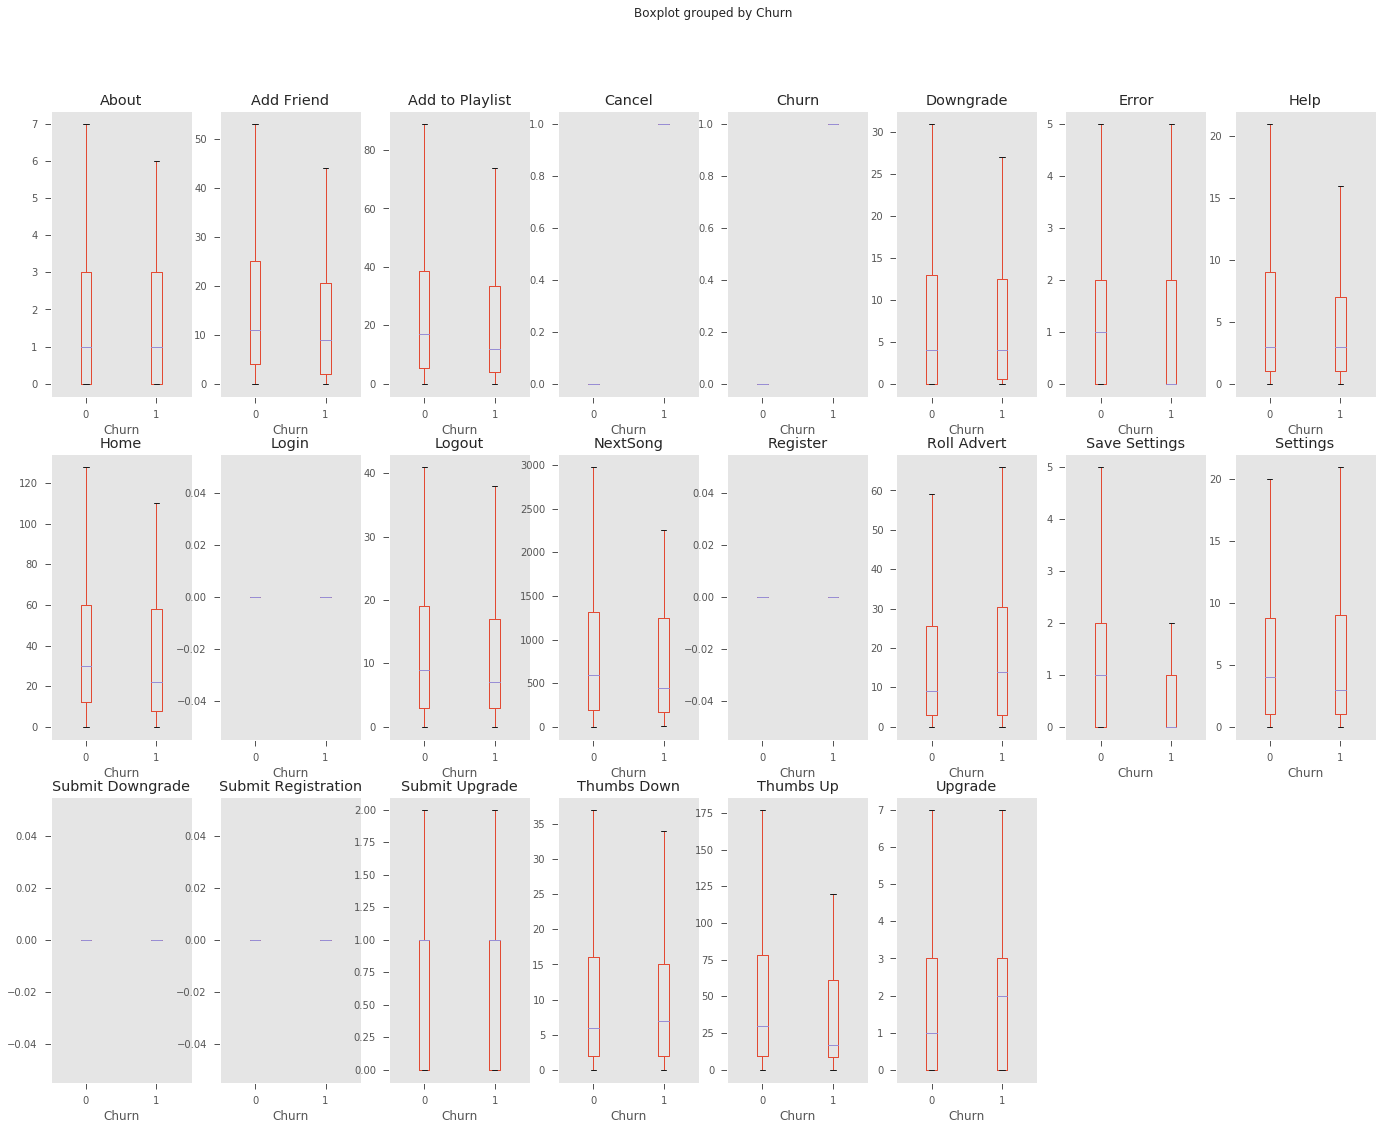

In [6]:
# check page list
page_types=spark.sql('''
          SELECT distinct page
          FROM users
          '''
          )
page_types.show()

# check page events based on churn
users_pivot = users.groupby(["userId"]).pivot("page").count().fillna(0).toPandas()
users_pivot = users_pivot.rename(columns={"Cancellation Confirmation": "Churn"})        
num_full_cols_list=users_pivot.columns.values.tolist()
assess_page_dist(users_pivot, num_full_cols_list[1:])

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [7]:
# check user statistic data
user_stats=users.select(users.columns).summary().toPandas().transpose()
user_stats

0                      1                     2  \
summary         count                   mean                stddev   
artist         432877      527.5289537712895     966.1072451772758   
auth           543705                   None                  None   
firstName      528005                   None                  None   
gender         528005                   None                  None   
itemInSession  543705     107.30629109535502    116.72350849188074   
lastName       528005                   None                  None   
length         432877     248.66459278007738     98.41266955051972   
level          543705                   None                  None   
location       528005                   None                  None   
method         543705                   None                  None   
page           543705                   None                  None   
registration   528005   1.535523414862437E12  3.0787254929957166E9   
sessionId      543705     2040.8143533717732     1434.338931078271   
song           432877               Infinity                   NaN   
status         543705     210.01829116892432    31.471919021567537   
ts             543705  1.5409645412098003E12  1.4820571449105084E9   
userAgent      528005                   None                  None   
userId         543705      60268.42669103512    109898.82324176628   

                                                               3  \
summary                                                      min   
artist                                                       !!!   
auth                                                   Cancelled   
firstName                                                Aaliyah   
gender                                                         F   
itemInSession                                                  0   
lastName                                                  Abbott   
length                                                   0.78322   
level                                                       free   
location                                               Akron, OH   
method                                                       GET   
page                                                       About   
registration                                       1509854193000   
sessionId                                                      1   
song                              
ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku   
status                                                       200   
ts                                                 1538352011000   
userAgent      "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...   
userId                                                             

                           4              5              6  \
summary                  25%            50%            75%   
artist                 112.0          311.0          702.0   
auth                    None           None           None   
firstName               None           None           None   
gender                  None           None           None   
itemInSession             26             68            147   
lastName                None           None           None   
length              199.3922      234.00444      276.79302   
level                   None           None           None   
location                None           None           None   
method                  None           None           None   
page                    None           None           None   
registration   1534367797000  1536555881000  1537611935000   
sessionId                630           1967           3307   
song                    22.0          221.0         1893.0   
status                   200            200            200   
ts             1539719995000  1541004525000  1542176431000   
userAgent               None           None           None   
userId                  96.0          201.0       100008.0   

                 

In [8]:
# check page list
page_types=spark.sql('''
          SELECT distinct page
          FROM users
          '''
          )
page_types.show()

# check user's device.
get_device = spark.udf.register("get_device", lambda x:x.split('(')[1].split(')')[0].split(';')[0], StringType())
spark.sql('''
          SELECT distinct get_device(userAgent)
          FROM users
          where userAgent is not null
          '''
          ).show()

#check user's location
spark.sql('''
          SELECT distinct right(location,2)
          FROM users
          '''
          ).collect()


+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows

+---------------------+
|get_device(userAgent)|
+---------------------+
|                 iPad|
|                  X11|
|       Windows NT 6.3|
|               iPhone|
|       Windows NT 6.2|
|            Macintosh|
|       Windows NT 5.1|
|           compatible|
|       Windows NT 6.0|
|       Windows NT 6.1|
+---------------------+



[Row(right(users.`location`, 2)='SC'),
 Row(right(users.`location`, 2)='AZ'),
 Row(right(users.`location`, 2)='LA'),
 Row(right(users.`location`, 2)='MN'),
 Row(right(users.`location`, 2)='NJ'),
 Row(right(users.`location`, 2)='OR'),
 Row(right(users.`location`, 2)='VA'),
 Row(right(users.`location`, 2)=None),
 Row(right(users.`location`, 2)='KY'),
 Row(right(users.`location`, 2)='NH'),
 Row(right(users.`location`, 2)='MI'),
 Row(right(users.`location`, 2)='NV'),
 Row(right(users.`location`, 2)='WI'),
 Row(right(users.`location`, 2)='ID'),
 Row(right(users.`location`, 2)='CA'),
 Row(right(users.`location`, 2)='CT'),
 Row(right(users.`location`, 2)='MT'),
 Row(right(users.`location`, 2)='NC'),
 Row(right(users.`location`, 2)='VT'),
 Row(right(users.`location`, 2)='MD'),
 Row(right(users.`location`, 2)='MO'),
 Row(right(users.`location`, 2)='IL'),
 Row(right(users.`location`, 2)='ME'),
 Row(right(users.`location`, 2)='WA'),
 Row(right(users.`location`, 2)='MS'),
 Row(right(users.`locatio

## Analysis:
- In order to analyze churn, the following in page actions are importance. 
 - Get user's device based on  userAgent and get the user's location.

 Next step will statistic above actions to generate some features.
 
 
 Next step will statistic above actions to generate some features.

# Data Preparation

##  Data Preprocessing
 -	Convert ts column from unixtime to timestamp
 -	For all the numeric feature, I combine them altogether by user_id and than scale all of them
 -	drop duplication in users views 
 -	Remove all the log activities with missing user_id via join actions in Feature Engineering step.

In [9]:
# 1 convert unixtime to timestamp
users = users.withColumn("date_time",  to_timestamp(from_unixtime(round(users.ts/1000), 'yyyy-MM-dd HH:mm:ss')))
users = users.withColumn("regist_time",  to_timestamp(from_unixtime(round(users.registration/1000), 'yyyy-MM-dd HH:mm:ss')))


#2 drop duplication in users based on ：userid， page， level， ts
users=users.drop_duplicates(subset=['userId','page','ts','level'])

users.createOrReplaceTempView("users")

In [10]:
user_log=spark.sql('''
          SELECT userId, date_format(regist_time,'yyyy-MM-dd HH:mm:ss') AS regist_time,
          date_format(date_time,'yyyy-MM-dd HH:mm:ss')  AS browse_time,level,page, auth, song,artist,ts
          FROM users
          where userId <> ''
          order by userId, date_time
          LIMIT 50000
          '''
          )


In [11]:
user_log.select("userId","regist_time","browse_time","level","page","auth")\
    .filter(user_log.page.isin('Register','Submit Upgrade','Cancellation Confirmation','Submit Downgrade') )\
    .orderBy("userId","browse_time").show(20)

+------+-------------------+-------------------+-----+--------------------+---------+
|userId|        regist_time|        browse_time|level|                page|     auth|
+------+-------------------+-------------------+-----+--------------------+---------+
|    10|2018-09-28 18:31:35|2018-10-09 03:22:44| paid|Cancellation Conf...|Cancelled|
|   100|2018-09-26 17:17:35|2018-10-02 10:54:43| free|      Submit Upgrade|Logged In|
|100001|2018-08-18 21:24:26|2018-10-02 14:50:59| free|Cancellation Conf...|Cancelled|
|100002|2018-06-25 13:51:29|2018-10-20 18:35:24| free|      Submit Upgrade|Logged In|
|100002|2018-06-25 13:51:29|2018-11-02 08:10:09| paid|    Submit Downgrade|Logged In|
|100003|2018-09-18 22:22:24|2018-10-27 22:19:47| free|      Submit Upgrade|Logged In|
|100003|2018-09-18 22:22:24|2018-11-08 07:19:52| paid|Cancellation Conf...|Cancelled|
|100004|2018-06-09 16:04:02|2018-10-14 10:13:00| free|Cancellation Conf...|Cancelled|
|100005|2018-07-26 13:15:26|2018-10-06 10:11:19| free|


## Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
  - Write a script to extract the necessary features from the smaller subset of data
  - Ensure that your script is scalable 
  - Try your script on the full data set, debugging your script if necessary

In [12]:
# # ------------------------------------------------------------------------------------
# # Feature Engineering

# If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#find out the last date.
last_date=spark.sql('''
          select userid, max(date_time) as last_date
          from users
          where userId <> ''
          group by userid
          order by userId
          '''
          )
last_date.createOrReplaceTempView("v_last_date")

#define users in last month
lm_users=spark.sql('''
          SELECT u.*
          from users as u join v_last_date as v on u.userid=v.userid
          where u.date_time  between date_sub(v.last_date,30)  and v.last_date
          order by u.userId, u.date_time
          '''
                  )
#define users in last 2 months.
l2m_users=spark.sql('''
          SELECT u.*
          from users as u join v_last_date as v on u.userid=v.userid
          where u.date_time  between date_sub(v.last_date,60)  and v.last_date
          order by u.userId, u.date_time
          '''
                  )
#define users in last week.
lw_users=spark.sql('''
          SELECT u.*
          from users as u join v_last_date as v on u.userid=v.userid
          where u.date_time  between date_sub(v.last_date,7)  and v.last_date
          order by u.userId, u.date_time
          '''
          )
#define users in last 2 weeks.
l2w_users=spark.sql('''
          SELECT u.*
          from users as u join v_last_date as v on u.userid=v.userid
          where u.date_time  between date_sub(v.last_date,14)  and v.last_date
          order by u.userId, u.date_time
          '''
          )
l2m_users.createOrReplaceTempView("l2m_users")
lm_users.createOrReplaceTempView("lm_users")
l2w_users.createOrReplaceTempView("l2w_users")
lw_users.createOrReplaceTempView("lw_users")


# Define the features
#--------------------------------------------------
# Feature
# week_active_ratio: activity ratio = register duration untillatest week/activity days(login days) in latest week
#--------------------------------------------------
# Feature base: register duration until latest week
LWReg = spark.sql("""
          select userid, last(week) as last_week, last(regist_days) as last_regist_days
          from (
            SELECT distinct userID, weekofyear(date_time) as week,
            case when datediff(date_time,regist_time)  > 7 then 7 else datediff(date_time,regist_time)  end as regist_days
            FROM lw_users
            WHERE auth='Logged In'
            order by userid,week
            )
          group by userid
          order by userid
            """)
#LWReg.show(300)

# Feature base: activity days(login days) in latest week
LWActivate = spark.sql("""
         select userid, last(week) as last_week, count(mday) as act_days_last_week
         from (
            SELECT userID, date_format(date_time,'MM-dd') as mday,weekofyear(date_time) as week
            FROM lw_users
            WHERE page in ('NextSong','Login')  and auth='Logged In'
            group by userID, mday, week
            order by userID, mday
            )
          group by userID
          order by userID
             """)
#LWActivate.show(300)

# Feature: activity ratio = register duration until latest week/activity days(login days) in latest week
LWAR=LWReg.join(LWActivate, ['userid','last_week'],'left_outer').sort(['userid','last_week'])
LWAR=LWAR.select(LWAR.userid,LWAR.last_week,            round(LWAR.act_days_last_week/LWAR.last_regist_days,4).alias("week_active_ratio"))
#LWAR.show()

#--------------------------------------------------
# Feature
# l2week_active_ratio: activity ratio = register duration untillatest 2 weeks/activity days(login days) in latest 2 weeks
#--------------------------------------------------
# Feature base: register duration until latest 2 weeks
L2WReg = spark.sql("""
          select userid, last(week) as last_week, last(regist_days) as last_regist_days
          from (
            SELECT distinct userID, weekofyear(date_time) as week,
            case when datediff(date_time,regist_time)  > 14 then 14 else datediff(date_time,regist_time)  end as regist_days
            FROM l2w_users
            WHERE auth='Logged In'
            order by userid,week
            )
          group by userid
          order by userid
            """)
#LWReg.show(300)


# Feature base: activity days(login days) in latest 2 weeks
L2WActivate = spark.sql("""
         select userid, last(week) as last_week, count(mday) as act_days_last_week
         from (
            SELECT userID, date_format(date_time,'MM-dd') as mday,weekofyear(date_time) as week
            FROM l2w_users
            WHERE page in ('NextSong','Login')  and auth='Logged In'
            group by userID, mday, week
            order by userID, mday
            )
          group by userID
          order by userID
             """)
#LWActivate.show(300)

# Feature: activity ratio = register duration until latest 2 weeks/activity days(login days) in latest 2 weeks
L2WAR=L2WReg.join(L2WActivate, ['userid','last_week'],'left_outer').sort(['userid','last_week'])
L2WAR=L2WAR.select(L2WAR.userid, round(L2WAR.act_days_last_week/L2WAR.last_regist_days,4).alias("l2week_active_ratio"))
#LWAR.show()

#--------------------------------------------------
# Feature
# month_active_ratio: activity ratio = register duration until latest mont/activity days(login days) in latest month
#--------------------------------------------------
# Feature base: register duration until latest month
LMReg = spark.sql("""
   select userid, last(month) as last_month, last(max_reg_days) as regist_days, last(regist_days) as last_regist_days
   from (
    select userid,month,max_reg_days, case when max_reg_days > month_days then month_days else max_reg_days end as regist_days
    from (
      select userid, max(reg_days) as max_reg_days, month , 30 as month_days
      from (
            SELECT userID, datediff(date_time,regist_time) as reg_days,month(date_time) as month, date_time
            FROM lm_users
            WHERE page in ('NextSong','Home')  and auth='Logged In'
            order by userid
            )
      group by userid, month
      )
     )
     group by userid
     order by userid
            """)
#LMReg.show(300)

# Feature base: activity days(login days) in latest month
LMActivate = spark.sql("""
     select userid, last(month) as last_month,  count(mday)  as act_days_last_month
     from (
            SELECT userID, date_format(date_time,'MM-dd') as mday,month(date_time) as month
            FROM lm_users
            WHERE page in ('NextSong','Login')  and auth='Logged In'
            group by userID, mday, month
            order by userID, mday
           )
     group by userID
     order by userID
            """)
#LMActivate.show(300)

# Feature: activity ratio = register duration until latest month/activity days(login days) in latest month
LMAR=LMReg.join(LMActivate, ['userid','last_month'],'left_outer').sort(['userid','last_month'])
LMAR=LMAR.select(LMAR.userid,LMAR.last_month,LMAR.regist_days, round(LMAR.act_days_last_month/LMAR.last_regist_days, 4).alias("month_active_ratio"))
#LMAR.show()

#--------------------------------------------------
# Feature:
# l2month_active_ratio: activity ratio = register duration until latest 2 months/activity days(login days) in latest 2 months
#--------------------------------------------------
# Feature base: register duration until latest 2 months
L2MReg = spark.sql("""
   select userid, last(month) as last_month, last(max_reg_days) as regist_days, last(regist_days) as last_regist_days
   from (
    select userid,month,max_reg_days, case when max_reg_days > month_days then month_days else max_reg_days end as regist_days
    from (
      select userid, max(reg_days) as max_reg_days, month , 60 as month_days
      from (
            SELECT userID, datediff(date_time,regist_time) as reg_days,month(date_time) as month, date_time
            FROM l2m_users
            WHERE page in ('NextSong','Home')  and auth='Logged In'
            order by userid
            )
      group by userid, month
      )
     )
     group by userid
     order by userid
            """)
#LMReg.show(300)

# Feature base: activity days(login days) in latest 2 months
L2MActivate = spark.sql("""
     select userid, last(month) as last_month,  count(mday)  as act_days_last_month
     from (
            SELECT userID, date_format(date_time,'MM-dd') as mday,month(date_time) as month
            FROM l2m_users
            WHERE page in ('NextSong','Login')  and auth='Logged In'
            group by userID, mday, month
            order by userID, mday
           )
     group by userID
     order by userID
            """)
#LMActivate.show(300)

# Feature: activity ratio = register duration until latest 2 months/activity days(login days) in latest 2 months
L2MAR=L2MReg.join(L2MActivate, ['userid','last_month'],'left_outer').sort(['userid','last_month'])
L2MAR=L2MAR.select(L2MAR.userid,
            round(L2MAR.act_days_last_month/L2MAR.last_regist_days, 4).alias("l2month_active_ratio"))
#LMAR.show()

#--------------------------------------------------
# Feature:
#   avg_songs_per_home: the average count for NextSong for every user per home visit
#   total_song_amount: total song amount per home visited
#--------------------------------------------------
is_home = spark.sql("""
            SELECT userID, page, ts, CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS is_home
            FROM users
            WHERE page in ('NextSong','Home')
            """)
# keep the results in a new view
is_home.createOrReplaceTempView("is_home_table")

# find the cumulative sum over the is_home column
cumulative_sum = spark.sql("""
    SELECT *, SUM(is_home) OVER
    (PARTITION BY userID ORDER BY ts asc ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period
    FROM is_home_table
    order by userID ,ts asc
    """)

# keep the results in a view
cumulative_sum.createOrReplaceTempView("period_table")

# Feature avg_songs_per_home:  the average count for NextSong for every user per home visit
Total_song=spark.sql('''
          SELECT userID, COUNT(*) AS total_song_amount,
            round(COUNT(*)/last(period),4) AS avg_songs_per_home
          FROM period_table
          where page = 'NextSong'
          GROUP BY userID
          order by userID
          ''')
#Total_song.show()

#--------------------------------------------------
# Feature:
#   rating_actions: rating action times in last month
#--------------------------------------------------
rating_Act = spark.sql("""
            SELECT userID, last(month(date_time)) as last_month, count(*) as rating_actions
            FROM lm_users
            WHERE page in ('Thumbs Down','Thumbs Up')  and auth='Logged In'
            group by userID
            order by userID
            """)
#rating_Act.show(300)

#--------------------------------------------------
# Feature:
#   negative_actions: negative behavior(downgrade/Cancel times ) in last month
#--------------------------------------------------
Neg_Act = spark.sql("""
            SELECT userID, last(month(date_time)) as last_month, count(*) as negative_actions
            FROM lm_users
            WHERE page in ('Downgrade','Cancel')  and auth='Logged In'
            group by userID
            order by userID
            """)
#Neg_Act.show()

#--------------------------------------------------
# Feature:
#   enjoy_songs_last_month: enjoy song times in last month
#   device: device to play song in last month
#   state : state where user live in the last month
#--------------------------------------------------
get_device = spark.udf.register("get_device", lambda x:x.split('(')[1].split(')')[0].split(';')[0],StringType())
Song_Act = spark.sql("""
            SELECT userID, count(*) as enjoy_songs_last_month,
            last(get_device(userAgent)) as device, last(right(location,2)) as state
            FROM lm_users
            WHERE page in ('NextSong')  and auth='Logged In' 
            and userAgent is not null and location is not null
            group by userID
            order by userID
            """)
#Song_Act.show(300)

#--------------------------------------------------
# Feature
#  lm_artist_avg: average artist number  in the lastest month
#  lm_diffsong_avg: average different song number in the lastest month
#  lm_itemInSession_avg: average itemInSession in the lastest month
#-------------------------------------------------

LMItems = spark.sql("""
          Select userID, round(count(distinct artist)/30,0) as lm_artist_avg, 
          round(count(distinct song)/30,0) as lm_diffsong_avg, 
          round(sum(avg_itemInSession)/30,0) as lm_itemInSession_avg
          FROM (
            SELECT userID, artist, song, avg(itemInSession) as avg_itemInSession
            FROM lm_users
            WHERE page in ('NextSong')  and auth='Logged In'
            group by userID, artist, song
            order by userID, artist, song
          )
          group by userID
          order by userID
            """)
#LMItems.show(20)

#--------------------------------------------------
# Feature base:
#  lm_song_avg: average number of enjoying songs in the lastest month
#  lm_use_avg:  average number of enjoying duration in the lastest month
#--------------------------------------------------
LMSongs = spark.sql("""
            SELECT userID, round(count(*)/30,4) as lm_song_avg, round(sum(length)/60/30,4) as lm_use_avg
            FROM lm_users
            WHERE page in ('NextSong')  and auth='Logged In'
            group by userID
            order by userID
            """)
#LMSongs.show()

#--------------------------------------------------
# Feature base:
#  l2m_use_avg: average number of enjoying songs in the lastest 2 months
#  l2m_use_avg:  average number of enjoying duration in the lastest 2 months
#--------------------------------------------------
L2MSongs = spark.sql("""
            SELECT userID, round(count(*)/60,4) as l2m_song_avg, round(sum(length)/60/60,4) as l2m_use_avg
            FROM l2m_users
            WHERE page in ('NextSong')  and auth='Logged In'
            group by userID
            order by userID
            """)
#L2MSongs.show()

#--------------------------------------------------
# Feature base:
#  l2w_song_avg: average number of enjoying songs in the lastest 2 weeks
#  l2w_use_avg:  average number of enjoying duration in the lastest 2 weeks
#--------------------------------------------------
L2WSongs = spark.sql("""
            SELECT userID, round(count(*)/14,4) as l2w_song_avg, round(sum(length)/60/14,4) as l2w_use_avg
            FROM l2w_users
            WHERE page in ('NextSong')  and auth='Logged In'
            group by userID
            order by userID
            """)
#L2WSongs.show()

#--------------------------------------------------
# Feature base:
#  lw_song_avg: average number of enjoying songs in the lastest  weeks
#  lw_use_avg:  average number of enjoying duration in the lastest weeks
#--------------------------------------------------
LWSongs = spark.sql("""
            SELECT userID, round(count(*)/7,4) as lw_song_avg, round(sum(length)/60/60,4) as lw_use_avg
            FROM lw_users
            WHERE page in ('NextSong')  and auth='Logged In'
            group by userID
            order by userID
            """)
#LWSongs.show()

#--------------------------------------------------
# Feature:
#  st_songs_trend: lw_song_avg/l2w_song_avg,
#  mt_songs_trend: l2w_song_avg/lm_song_avg
#  lt_songs_trend: lm_song_avg/l2m_song_avg
#  st_use_trend :  lw_use_avg/l2w_use_avg
#  mt_use_trend :  l2w_use_avg/lm_use_avg
#  lt_use_trend :  lm_use_avg/ l2m_use_avg
#--------------------------------------------------
Song_avgs=L2MSongs.join(LMSongs, ['userid'],'left_outer').sort(['userid'])
Song_avgs=Song_avgs.join(L2WSongs, ['userid'],'left_outer').sort(['userid'])
Song_avgs=Song_avgs.join(LWSongs, ['userid'],'left_outer').sort(['userid'])
#Song_avgs.show()
# calcuate trend
Song_avgs=Song_avgs.select(Song_avgs.userID,
                           when(Song_avgs.l2w_song_avg.isNotNull(),round(Song_avgs.lw_song_avg/Song_avgs.l2w_song_avg, 4)).\
                               otherwise(0).alias("st_songs_trend"),
                           when(Song_avgs.lm_song_avg.isNotNull(),round(Song_avgs.l2w_song_avg/Song_avgs.lm_song_avg, 4)).\
                               otherwise(0).alias("mt_songs_trend"),
                           when(Song_avgs.l2m_song_avg.isNotNull(),round(Song_avgs.lm_song_avg/Song_avgs.l2m_song_avg, 4)).\
                               otherwise(0).alias("lt_songs_trend"),
                           when(Song_avgs.l2w_use_avg.isNotNull(),round(Song_avgs.lw_use_avg/Song_avgs.l2w_use_avg, 4)).\
                               otherwise(0).alias("st_use_trend"),
                           when(Song_avgs.lm_use_avg.isNotNull(),round(Song_avgs.l2w_use_avg/Song_avgs.lm_use_avg, 4)).\
                               otherwise(0).alias("mt_use_trend"),
                           when(Song_avgs.l2m_use_avg.isNotNull(),round(Song_avgs.lm_use_avg/Song_avgs.l2m_use_avg, 4)).\
                               otherwise(0).alias("lt_use_trend"))
#Song_avgs.show()
#--------------------------------------------------
# Feature:
#  churn: the user cancel the account in last month
#  gender: the user's gender
#--------------------------------------------------
Churn_Act = spark.sql("""
         select userid, last(month(date_time)) as churn_month,last(paid_flag) as paid_flag, last(gender_code) as gender_code, last(churn) as churn
         from (
            SELECT userID, date_time ,
            case when level = 'paid' then 1 else 0 end as paid_flag,
            case when gender ='M' then 1 else 0 end as gender_code,
            case when page ='Cancellation Confirmation' then 1 else 0 end as churn
            FROM lm_users
            WHERE page in ('Cancellation Confirmation','NextSong')
            order by userID, date_time, gender
            )
         group by userID
         order by userID, churn_month
            """)

In [13]:
#--------------------------------------------------
# Feature
# lt_trend_of_about  : lt_trend_of_about   in the last 2 month
# lt_trend_of_add_friend    : lt_trend_of_add_friend in the last 2 month
# lt_trend_of_add_playlist  : lt_trend_of_add_playlist in the last 2 month
# lt_trend_of_help : lt_trend_of_help in the last 2 month
# lt_trend_of_setting:lt_trend_of_setting in the last 2 month
# lt_trend_of_error: lt_trend_of_error in the last 2 month
# mt_trend_of_about  : mt_trend_of_about   in the 2 weeks interval
# mt_trend_of_add_friend    : mt_trend_of_add_friend in the 2 weeks interval
# mt_trend_of_add_playlist  : mt_trend_of_add_playlist in the 2 weeks interval
# mt_trend_of_help : mt_trend_of_help in the 2 weeks interval
# mt_trend_of_setting:mt_trend_of_setting in the 2 weeks interval
# mt_trend_of_error: mt_trend_of_error in the 2 weeks interval
#-------------------------------------------------
# Page events lastest 2 week
L2WPages = l2w_users.groupBy("userID", "page")\
    .pivot("page",["About","Add Friend","Add to Playlist","Help","Setting","Error"])\
    .count().fillna(0)
L2WPages=L2WPages.select("userID","About","Add Friend","Add to Playlist","Help","Setting","Error")\
        .groupBy("userID").sum().orderBy('userID')
L2WPages = L2WPages.withColumnRenamed('sum(About)', 'l2w_sum_of_about')\
    .withColumnRenamed('sum(Add Friend)', 'l2w_sum_of_add_friend')\
    .withColumnRenamed('sum(Add to Playlist)', 'l2w_sum_of_add_playlist')\
    .withColumnRenamed('sum(Help)', 'l2w_sum_of_help')\
    .withColumnRenamed('sum(Setting)', 'l2w_sum_of_setting')\
    .withColumnRenamed('sum(Error)', 'l2w_sum_of_error') \
    .orderBy('userID')
# Page events lastest 1 month
LMPages = lm_users.groupBy("userID", "page")\
    .pivot("page",["About","Add Friend","Add to Playlist","Help","Setting","Error"])\
    .count().fillna(0)
LMPages=LMPages.select("userID","About","Add Friend","Add to Playlist","Help","Setting","Error")\
        .groupBy("userID").sum().orderBy('userID')
LMPages = LMPages.withColumnRenamed('sum(About)', 'lm_sum_of_about')\
    .withColumnRenamed('sum(Add Friend)', 'lm_sum_of_add_friend')\
    .withColumnRenamed('sum(Add to Playlist)', 'lm_sum_of_add_playlist')\
    .withColumnRenamed('sum(Help)', 'lm_sum_of_help')\
    .withColumnRenamed('sum(Setting)', 'lm_sum_of_setting')\
    .withColumnRenamed('sum(Error)', 'lm_sum_of_error') \
    .orderBy('userID')
# Page events lastest 2 month 
L2MPages = l2m_users.groupBy("userID", "page")\
    .pivot("page",["About","Add Friend","Add to Playlist","Help","Setting","Error"])\
    .count().fillna(0)
L2MPages=L2MPages.select("userID","About","Add Friend","Add to Playlist","Help","Setting","Error")\
        .groupBy("userID").sum().orderBy('userID')
L2MPages = L2MPages.withColumnRenamed('sum(About)', 'l2m_sum_of_about')\
    .withColumnRenamed('sum(Add Friend)', 'l2m_sum_of_add_friend')\
    .withColumnRenamed('sum(Add to Playlist)', 'l2m_sum_of_add_playlist')\
    .withColumnRenamed('sum(Help)', 'l2m_sum_of_help')\
    .withColumnRenamed('sum(Setting)', 'l2m_sum_of_setting')\
    .withColumnRenamed('sum(Error)', 'l2m_sum_of_error') \
    .orderBy('userID')

# middle term trend
MT_trend_base=LMPages.join(L2WPages, ['userid'],'left_outer').sort(['userid']) 
MT_trend= MT_trend_base.select(MT_trend_base.userID,\
                round((MT_trend_base.l2w_sum_of_about/7-MT_trend_base.lm_sum_of_about/30),4).alias('mt_trend_of_about'),\
                round((MT_trend_base.l2w_sum_of_add_friend/7-MT_trend_base.lm_sum_of_add_friend/30),4).alias('mt_trend_of_add_friend'),\
                round((MT_trend_base.l2w_sum_of_add_playlist/7-MT_trend_base.lm_sum_of_add_playlist/30),4).alias('mt_trend_of_add_playlist'),\
                round((MT_trend_base.l2w_sum_of_help/7-MT_trend_base.lm_sum_of_help/30),4).alias('mt_trend_of_help'),\
                round((MT_trend_base.l2w_sum_of_setting/7-MT_trend_base.lm_sum_of_setting/30),4).alias('mt_trend_of_setting'),\
                round((MT_trend_base.l2w_sum_of_error/7-MT_trend_base.lm_sum_of_error/30),4).alias('mt_trend_of_error')
               )
#MT_trend.show()
# long term trend
LT_trend_base=L2MPages.join(LMPages, ['userid'],'left_outer').sort(['userid']) 
LT_trend= LT_trend_base.select(LT_trend_base.userID,\
                round((LT_trend_base.lm_sum_of_about/30-LT_trend_base.l2m_sum_of_about/60),4).alias('lt_trend_of_about'),\
                round((LT_trend_base.lm_sum_of_add_friend/30-LT_trend_base.l2m_sum_of_add_friend/60),4).alias('lt_trend_of_add_friend'),\
                round((LT_trend_base.lm_sum_of_add_playlist/30-LT_trend_base.l2m_sum_of_add_playlist/60),4).alias('lt_trend_of_add_playlist'),\
                round((LT_trend_base.lm_sum_of_help/30-LT_trend_base.l2m_sum_of_help/60),4).alias('lt_trend_of_help'),\
                round((LT_trend_base.lm_sum_of_setting/30-LT_trend_base.l2m_sum_of_setting/60),4).alias('lt_trend_of_setting'),\
                round((LT_trend_base.lm_sum_of_error/30-LT_trend_base.l2m_sum_of_error/60),4).alias('lt_trend_of_error')
               )
#LT_trend.show()

In [14]:
# ------------------------------------------------------------------------------
# Combine all features
features=LMAR.join(LWAR, ['userid'],'left_outer').sort(['userid'])
features=features.join(L2MAR, ['userid'],'left_outer').sort(['userid'])
features=features.join(L2WAR, ['userid'],'left_outer').sort(['userid'])
features=features.join(Total_song, ['userid'],'left_outer').sort(['userid'])
features=features.join(rating_Act, ['userid','last_month'],'left_outer').sort(['userid','last_month'])
features=features.join(Neg_Act, ['userid','last_month'],'left_outer').sort(['userid','last_month'])
features=features.join(Song_Act,  ['userid'],'left_outer').sort(['userid'])
features=features.join(Churn_Act, ['userid'],'left_outer').sort(['userid'])
features=features.join(Song_avgs, ['userid'],'left_outer').sort(['userid'])
features=features.join(LMItems, ['userid'],'left_outer').sort(['userid'])
features=features.join(MT_trend, ['userid'],'left_outer').sort(['userid'])
features=features.join(LT_trend, ['userid'],'left_outer').sort(['userid'])
features_act=features.select(features.userid,
                           when(features.l2week_active_ratio.isNotNull(),round(features.week_active_ratio/features.l2week_active_ratio, 4)).\
                               otherwise(0).alias("st_active_trend"),
                           when(features.month_active_ratio.isNotNull(),round(features.l2week_active_ratio/features.month_active_ratio, 4)).\
                               otherwise(0).alias("mt_active_trend"),
                           when(features.month_active_ratio.isNotNull(),round(features.month_active_ratio/features.l2month_active_ratio, 4)).\
                               otherwise(0).alias("lt_active_trend"))
features=features.join(features_act, ['userid'],'left_outer').sort(['userid'])
# load to memory
features.cache()

# convert string userid to int.
features=features.withColumn("user_id" ,features.userid.cast('int'))

#convert device, state to category variables
si_device = StringIndexer(inputCol="device", outputCol="device_code", handleInvalid="skip")
model_device = si_device.fit(features)
features = model_device.transform(features)
si_state = StringIndexer(inputCol="state", outputCol="state_code", handleInvalid="skip")
model_state = si_state.fit(features)
features = model_state.transform(features)

# handle the missing value
features=features.fillna(0)

# drop temp columns: last_month, last_week,churn_month 
temp_cols_list=['last_month','last_week','churn_month','userid','device','state']
for col in temp_cols_list:
    features=features.drop(col)

features_df = features.toPandas()
#features.show()
features_df.to_json("feature_stat.json")


## Features Distribution Analysis:
It includes the following:
 - missing value；
 - flier
 - inconsistent data；
 - error data
 
 ###  Data Visualization
  - use boxplot for flier data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 40 columns):
regist_days                 447 non-null int32
month_active_ratio          447 non-null float64
week_active_ratio           447 non-null float64
l2month_active_ratio        447 non-null float64
l2week_active_ratio         447 non-null float64
total_song_amount           447 non-null int64
avg_songs_per_home          447 non-null float64
rating_actions              447 non-null int64
negative_actions            447 non-null int64
enjoy_songs_last_month      447 non-null int64
paid_flag                   447 non-null int32
gender_code                 447 non-null int32
churn                       447 non-null int32
st_songs_trend              447 non-null float64
mt_songs_trend              447 non-null float64
lt_songs_trend              447 non-null float64
st_use_trend                447 non-null float64
mt_use_trend                447 non-null float64
lt_use_trend                4

regist_days  month_active_ratio  week_active_ratio  l2month_active_ratio  \
0           11              0.1818             0.2857                0.1818   
1           65              0.7333             1.0000                0.6000   
2           45              0.0667             0.2857                0.0444   
3          130              0.1333             0.2857                0.0667   
4           51              0.3333             0.5714                0.1961   

   l2week_active_ratio  total_song_amount  avg_songs_per_home  rating_actions  \
0               0.1818                360             24.0000              18   
1               0.8571               3382             43.3590             108   
2               0.1429                 96             24.0000               6   
3               0.2143                137             11.4167              10   
4               0.0000                661             21.3226              26   

   negative_actions  enjoy_songs_last_month     ...      \
0                 2                     360     ...       
1                23                    2092     ...       
2                 1                      96     ...       
3                 2                     137     ...       
4                13                     661     ...       

   lt_trend_of_add_playlist  lt_trend_of_help  lt_trend_of_setting  \
0                    0.2333            0.0500                  0.0   
1                    0.3667            0.0833                  0.0   
2                    0.0500            0.0167                  0.0   
3                    0.0500            0.0333                  0.0   
4                    0.3167            0.0500                  0.0   

   lt_trend_of_error  st_active_trend  mt_active_trend  lt_active_trend  \
0             0.0167           1.5715           1.0000           1.0000   
1             0.0500           0.0000           0.0000           0.0000   
2             0.0000           1.9993           2.1424           1.5023   
3             0.0000           1.3332           1.6077           1.9985   
4             0.0167           0.0000           0.0000           1.6996   

   user_id  device_code  state_code  
0       10          0.0        27.0  
1      100          1.0         1.0  
2   100001          0.0         4.0  
3   100002          1.0         0.0  
4   100003          1.0         4.0  

[5 rows x 40 columns]

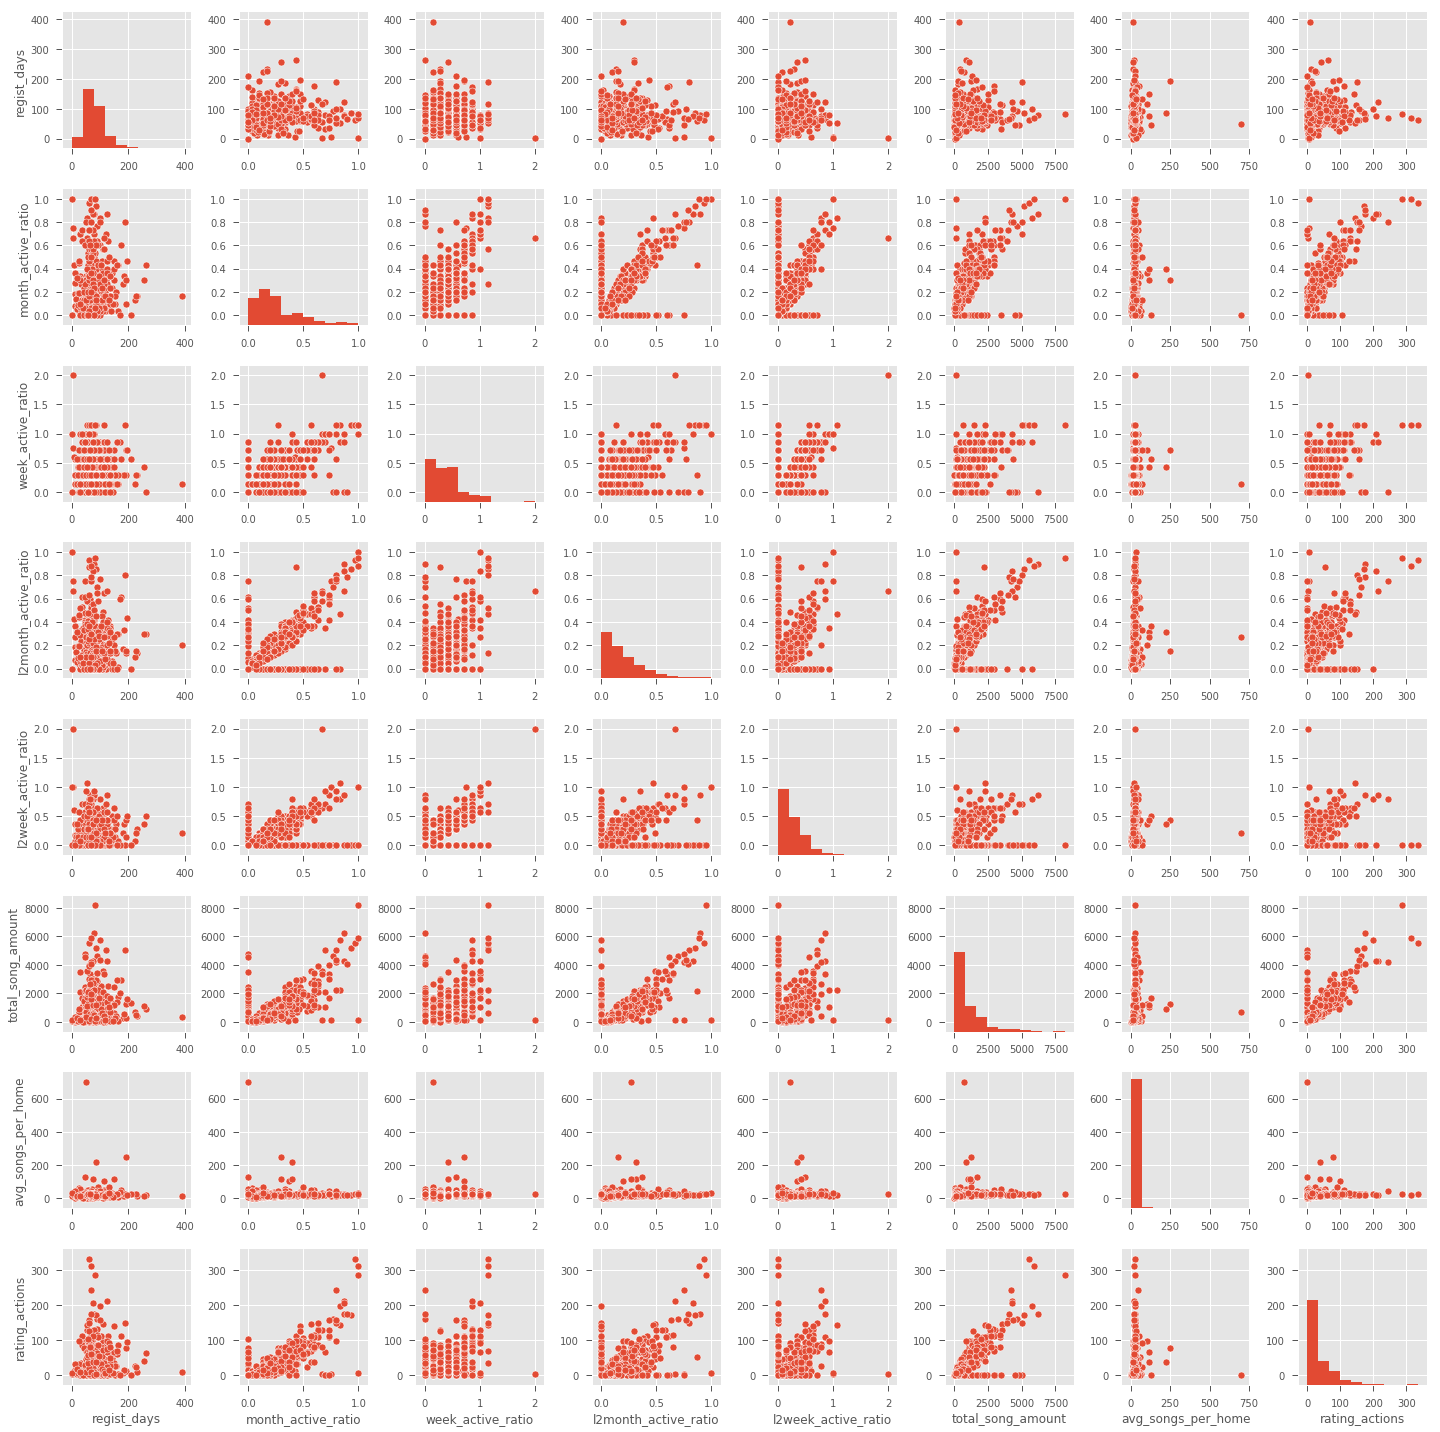

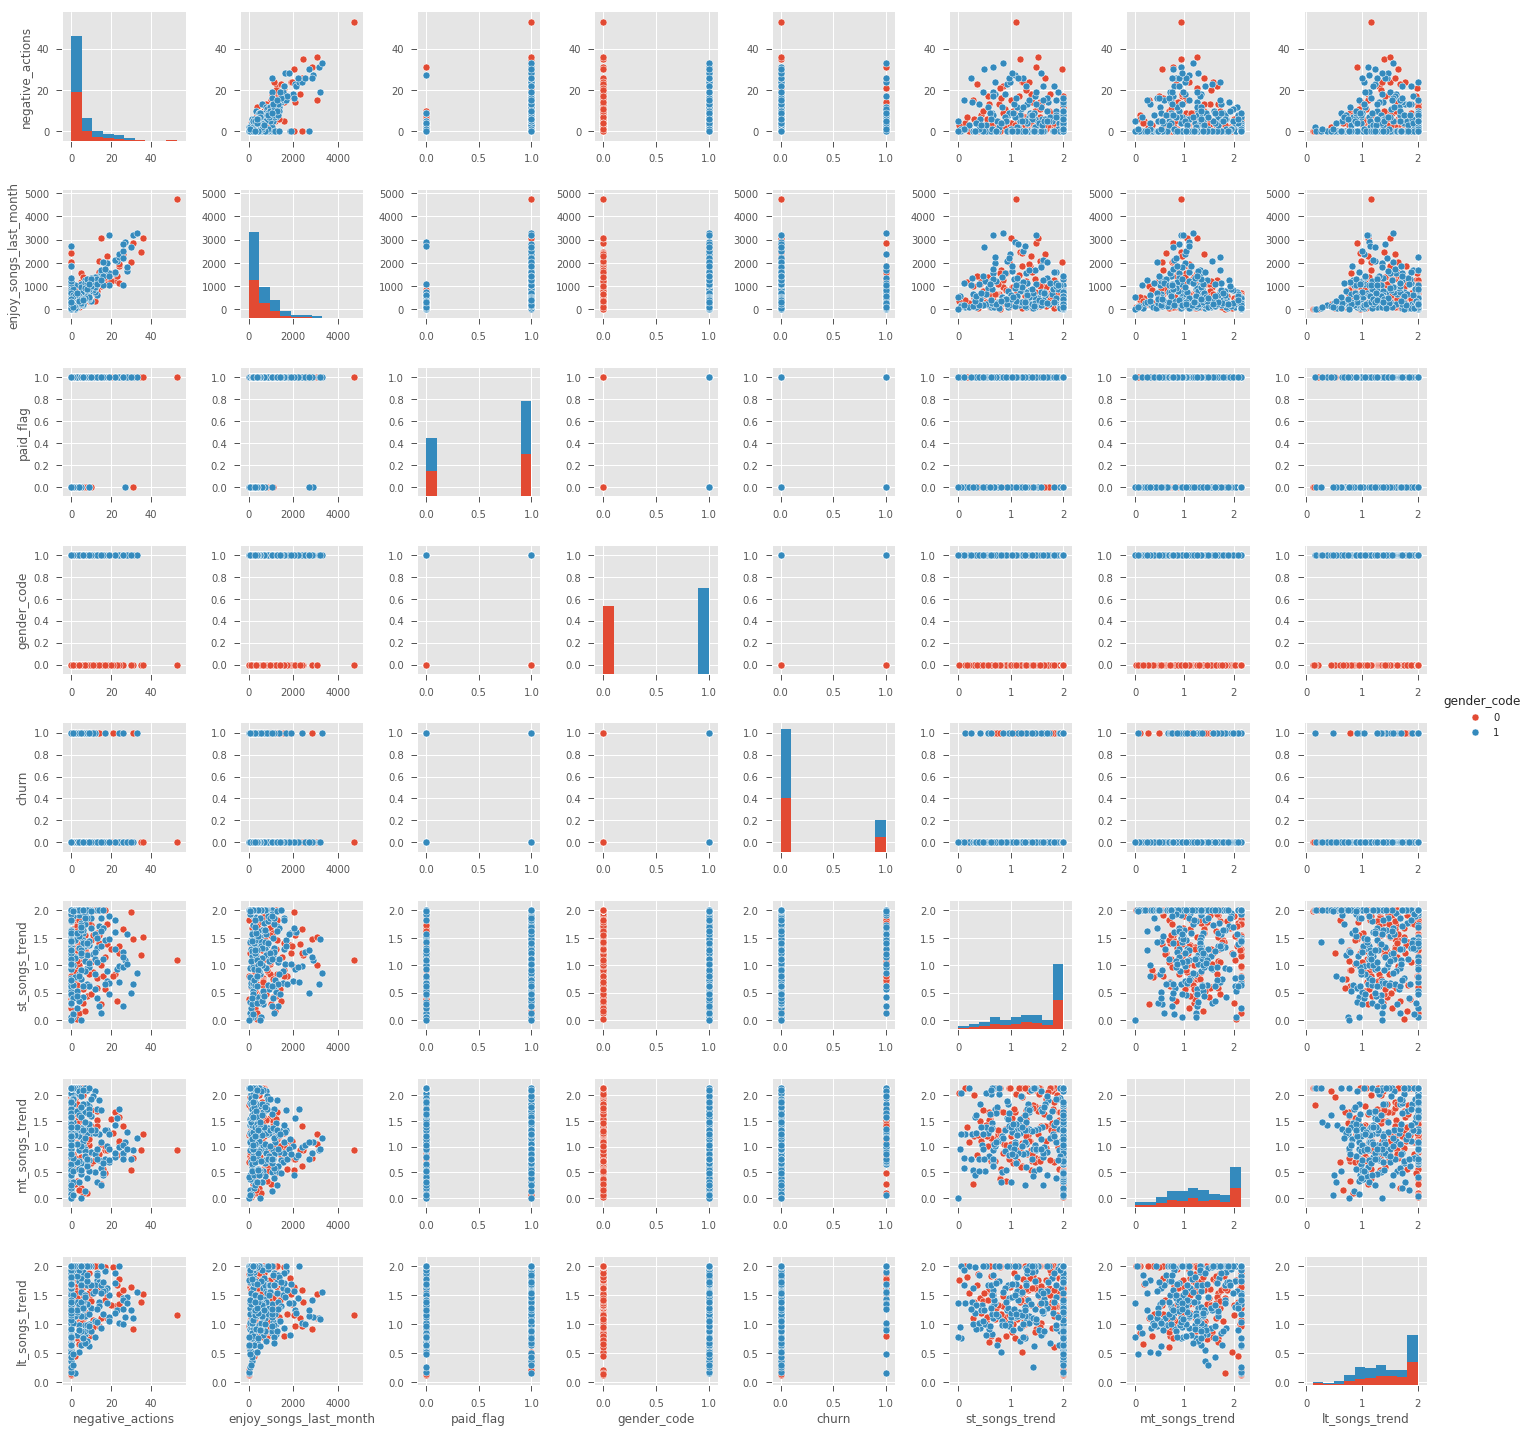

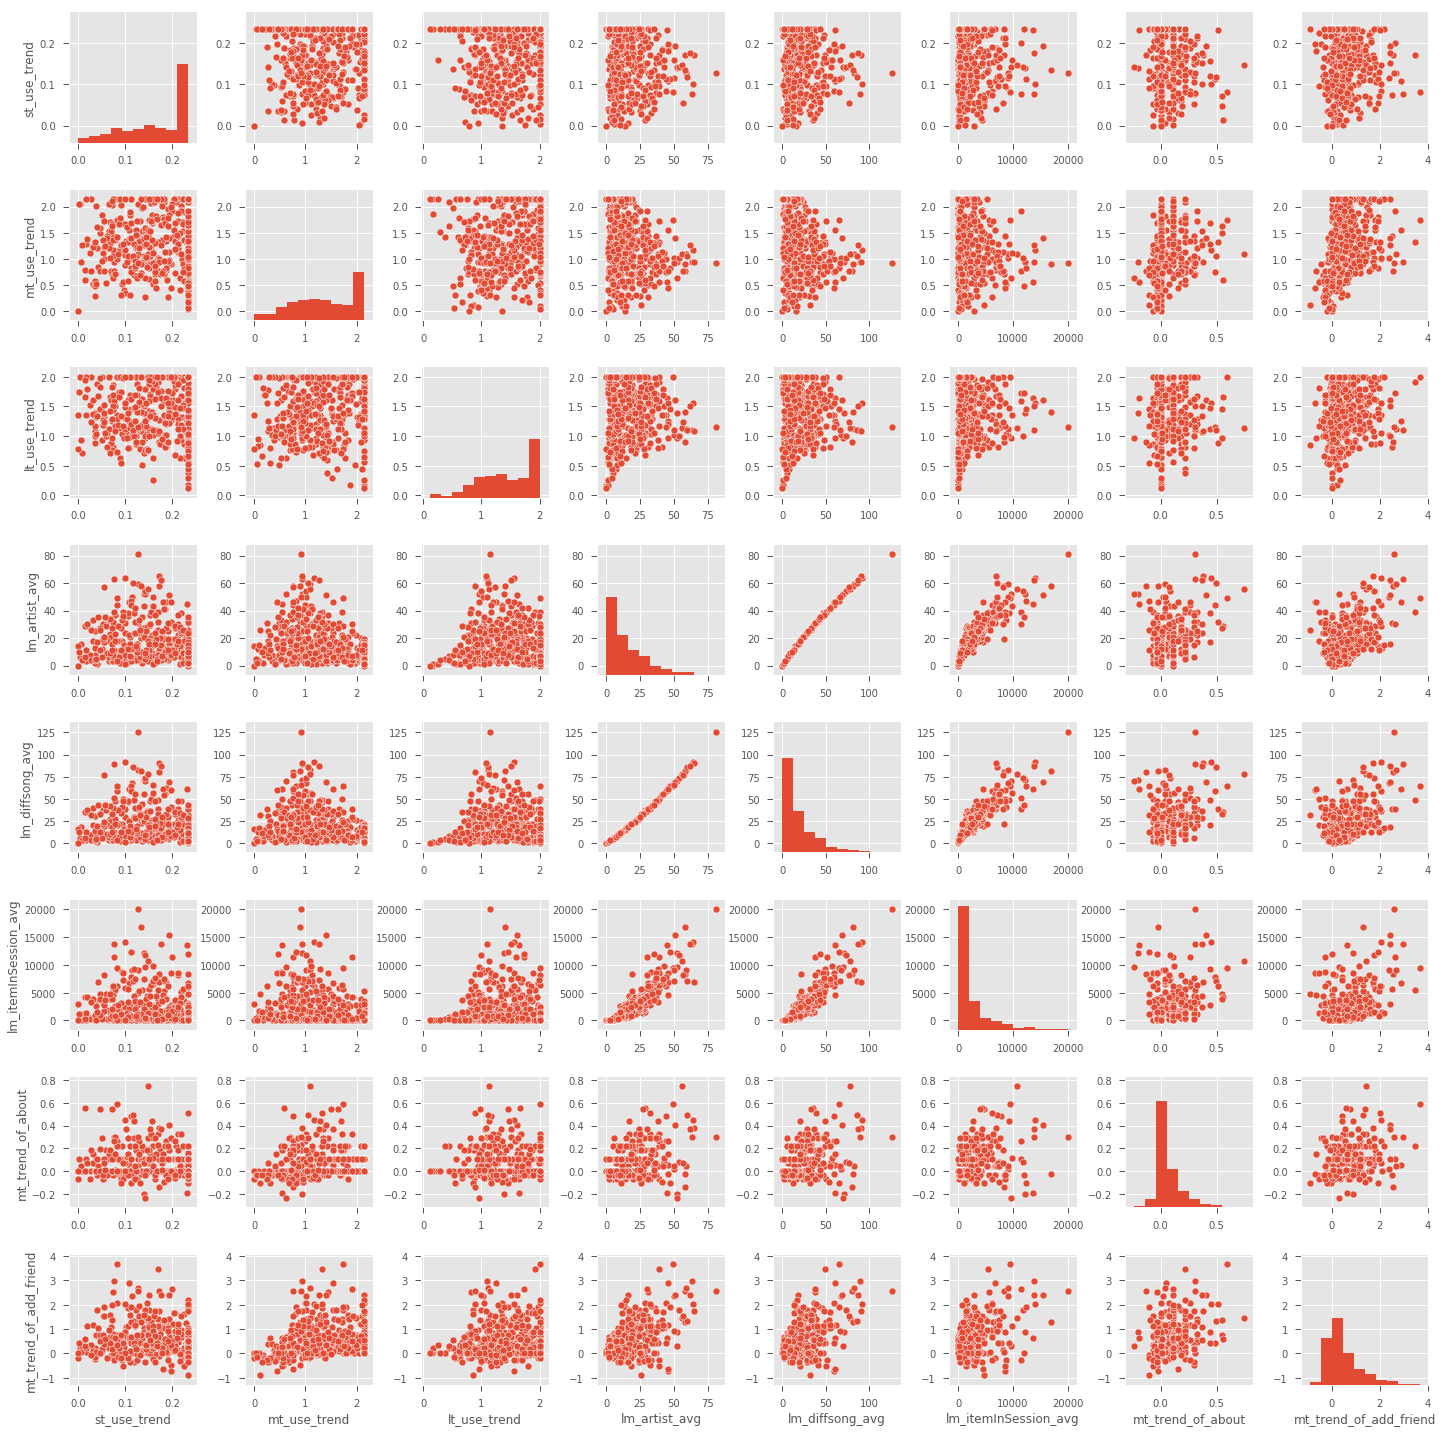

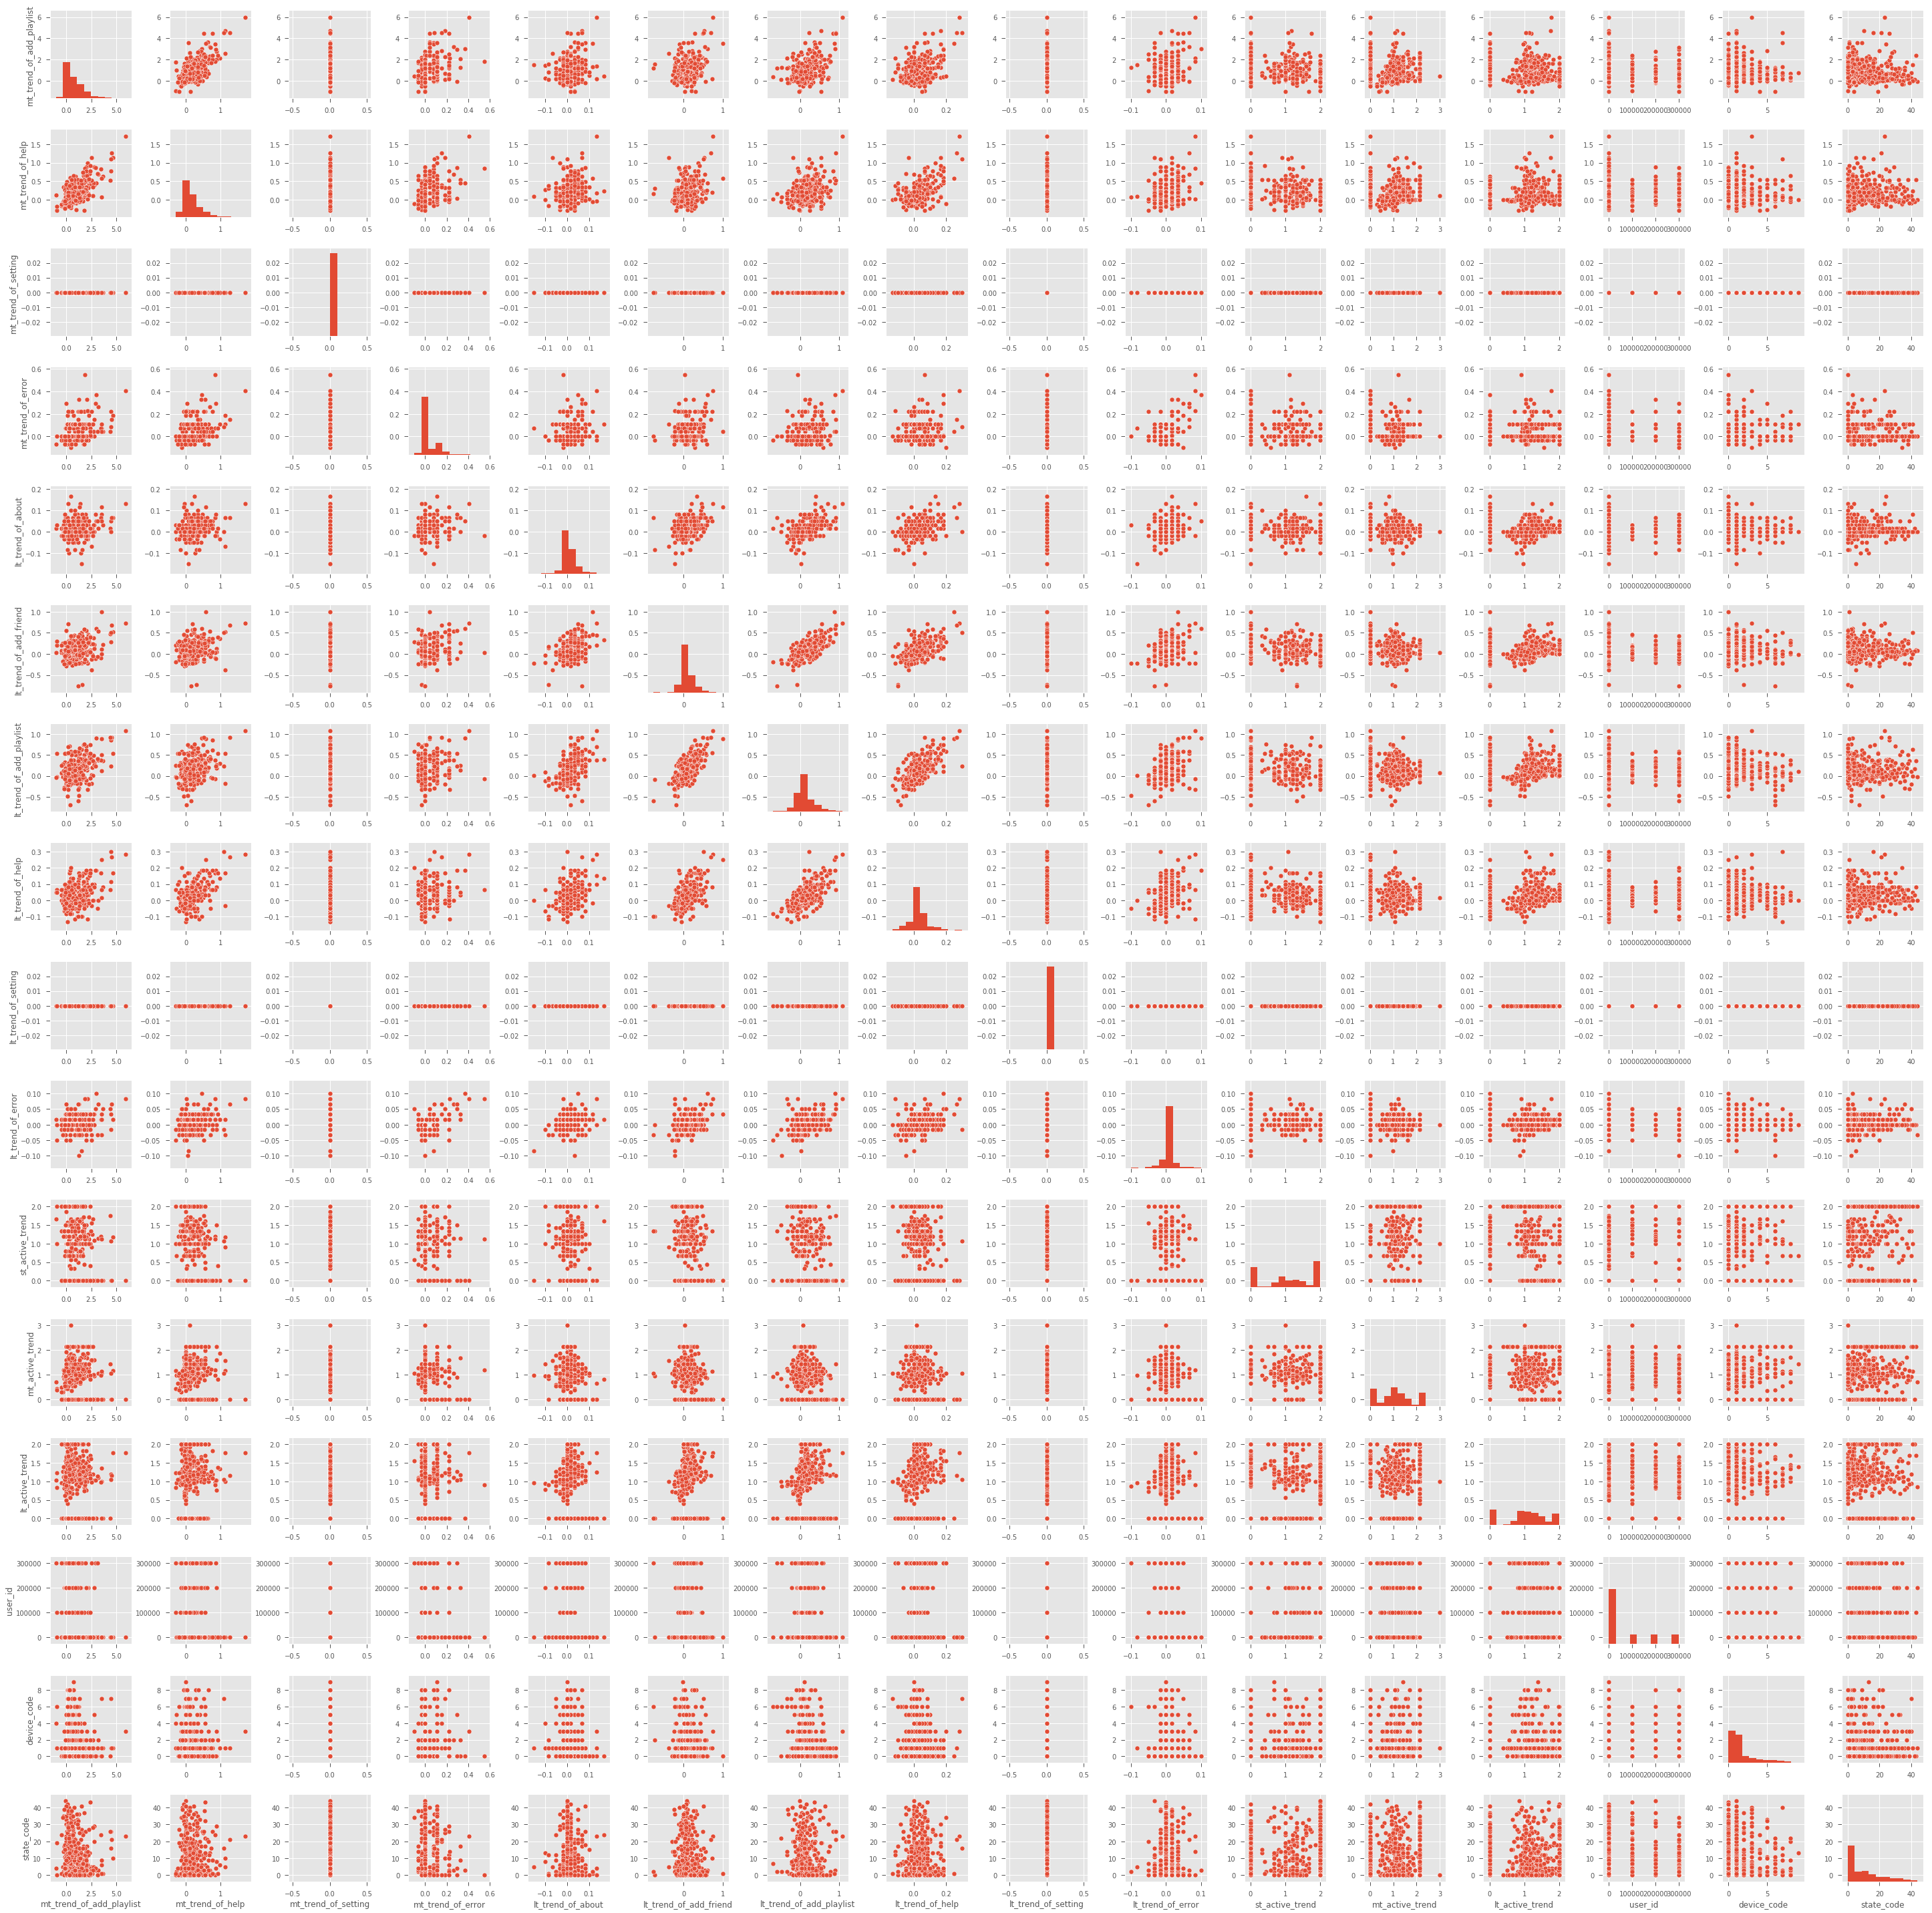

In [15]:
print(features_df.info())
# use pairplot to analysis correlation, 
# if serveral features has high correlation and keep one and remove others
sns_df=features_df.select_dtypes(include=[np.number])
spp = sns.pairplot(sns_df.iloc[:,:8])
spp = sns.pairplot(sns_df.iloc[:,8:16], hue="gender_code")
spp = sns.pairplot(sns_df.iloc[:,16:24] )
spp = sns.pairplot(sns_df.iloc[:,24:] )
features_df.head()

##  analysis
 - "st_songs_trend","mt_songs_trend","lt_songs_trend" has high correlation with "st_use_trend","mt_use_trend","lt_use_trend". so remove "st_use_trend","mt_use_trend","lt_use_trend".
 - user_id should not be used , it will be identify for a user.

In [16]:
def assess_extream_for_numeric(df, num_full_cols_list):
    """
    Function description: 
       Assess extream values distribution for columns with no missing value. 
    Input:
        df: Dataframe, dataset 
        num_full_cols_list:numeric columns to be assessed.
    Return:
        NA   
    """
    """
    Function description: 
       Assess extream values distribution for columns with no missing value. 
    Input:
        df: Dataframe, dataset 
        num_full_cols_list:full numeric columns to be assessed.
    Return:
        NA   
    """
    # calculate how many subplots and set figure size 
    count=len(num_full_cols_list)
    base_width=8
    base_high=2
    max_row_figures=2
    if count> max_row_figures:
        width= max_row_figures*base_width
        rows= count//max_row_figures+1
        high = base_high*rows
    else:
        width=2*base_width
        rows=2
        high =base_high

    # set figure styple
    plt.style.use('ggplot')
    sns.set_style('darkgrid')
    sns.set_palette('muted')
    # set figure size
    fig_gap=2*rows
    plt.figure(figsize=(width,high+fig_gap))
    i=1
    for col in num_full_cols_list:
        plt.subplot(rows,max_row_figures,i ) 
        sns.boxplot(data=df[col],orient="h",palette="Set3")  #水平显示
        i=i+1
        plt.title('{} Box Plot'.format(col))

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


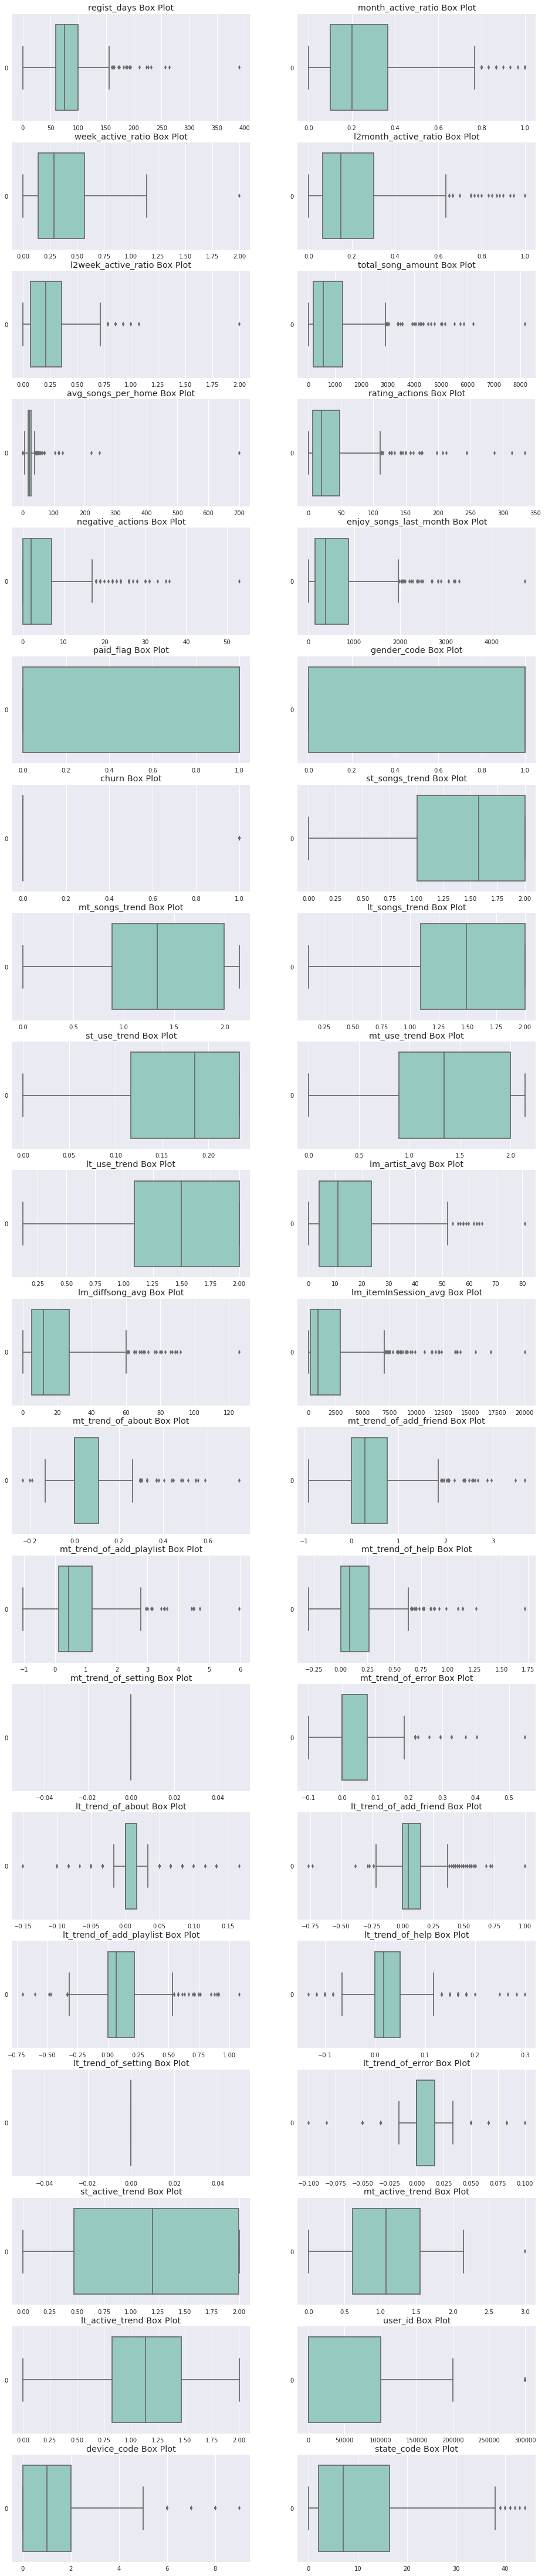

In [17]:
feat_num_cols=features_df.select_dtypes(exclude=['object','category']).columns.values.tolist()
assess_extream_for_numeric(features_df, feat_num_cols)

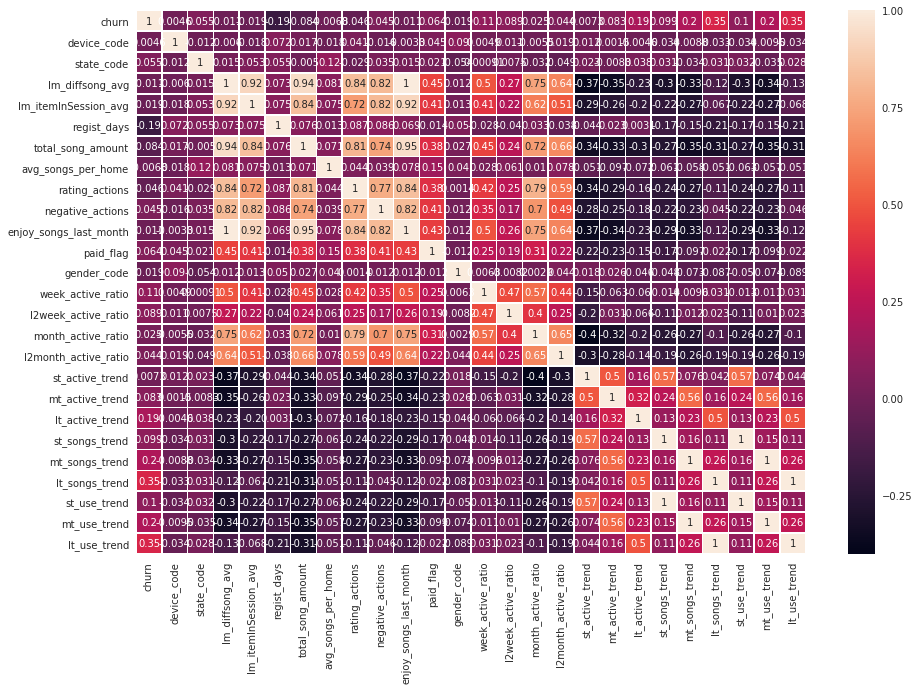

In [18]:
#heatmap plot for varriables correlation
internal_chars=["churn","device_code","state_code","lm_diffsong_avg","lm_itemInSession_avg",
                "regist_days","total_song_amount","avg_songs_per_home","rating_actions",
               "negative_actions","enjoy_songs_last_month","paid_flag","gender_code",
                "week_active_ratio","l2week_active_ratio","month_active_ratio","l2month_active_ratio",
                "st_active_trend","mt_active_trend","lt_active_trend",
                "st_songs_trend","mt_songs_trend","lt_songs_trend",
               "st_use_trend","mt_use_trend","lt_use_trend"]
corrmat = features_df[internal_chars].corr()
f, ax = plt.subplots(figsize=(15, 10))
plt.xticks(rotation='0')
sns.heatmap(corrmat, square=False, linewidths=.5, annot=True)

# Data Distribution analysis:

In [19]:
def assess_dist_for_numeric(df, num_full_cols_list):
    """
    Function description: 
       Assess values distribution for columns with no missing value. 
    Input:
        df: Dataframe, dataset 
        num_full_cols_list:numeric columns to be assessed.
    Return:
        NA   
    """
    """
    Function description: 
       Assess values distribution for columns with no missing value. 
    Input:
        df: Dataframe, dataset 
        num_full_cols_list:full numeric columns to be assessed.
    Return:
        NA   
    """
    # calculate how many subplots and set figure size 
    count=len(num_full_cols_list)
    base_width=5
    base_high=4
    max_row_figures=4
    if count> max_row_figures:
        width= max_row_figures*base_width
        rows= count//max_row_figures+1
        high = base_high*rows
    else:
        width=count*base_width
        rows=2
        high =base_high
    # set figure styple
    plt.style.use('ggplot')
    sns.set_style('darkgrid')
    sns.set_palette('muted')
    # set figure size
    fig_gap=3
    plt.figure(figsize=(width,high+fig_gap))
    i=1
    for col in num_full_cols_list:
        plt.subplot(rows,max_row_figures,i)
        i=i+1
        sns.distplot(df.loc[df[col].notnull(),[col]], label=col)
        plt.title('{} Distribution'.format(col))
        plt.legend();

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


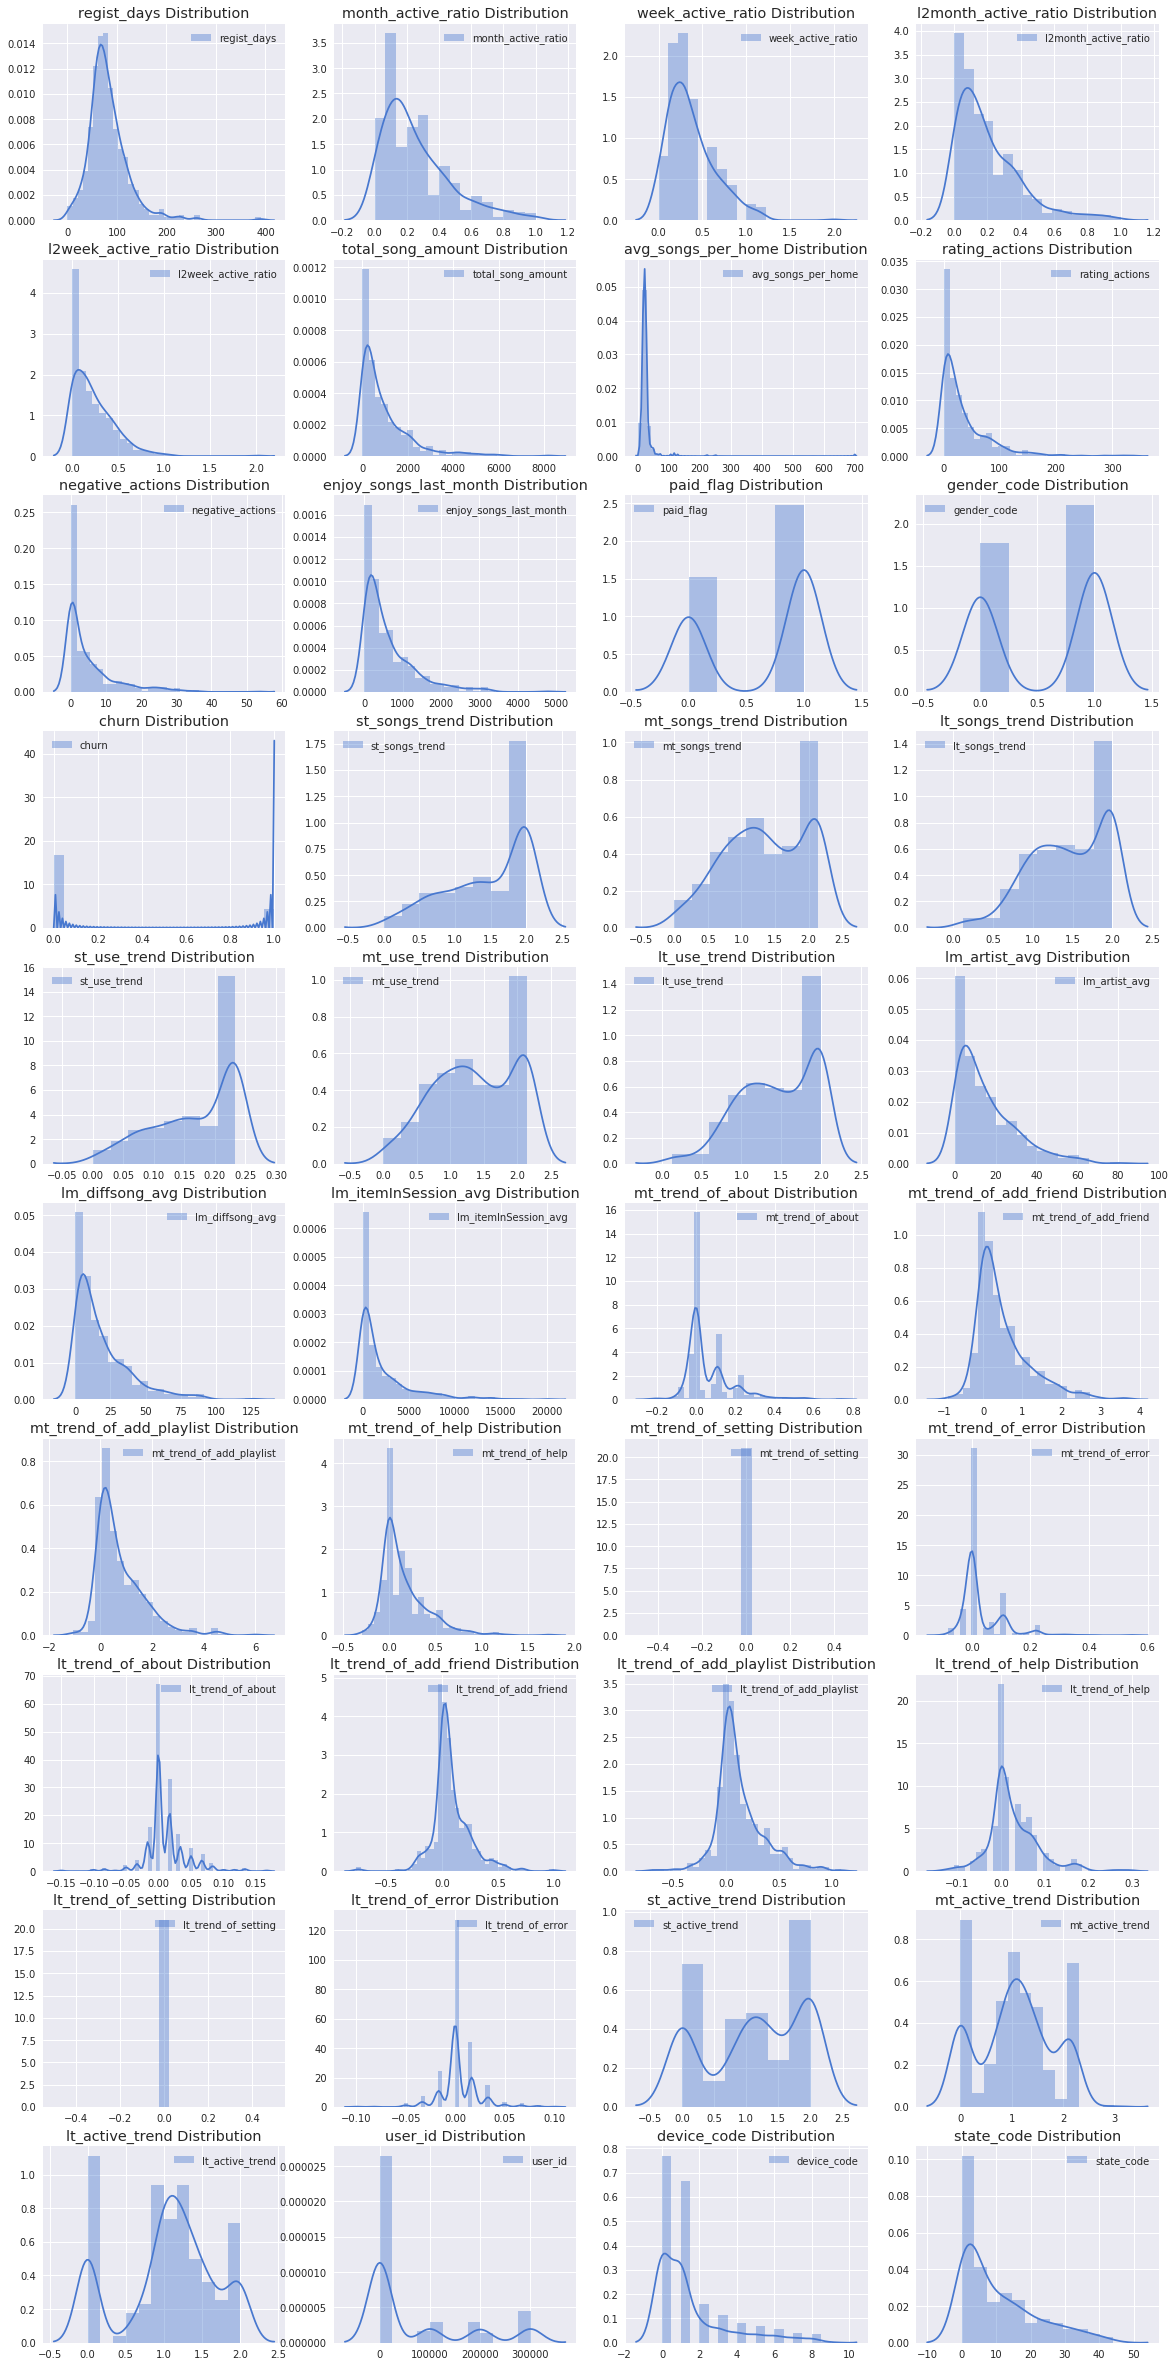

In [20]:
num_full_cols_list=features_df.select_dtypes(exclude=['object']).columns.values.tolist()
assess_dist_for_numeric(features_df,num_full_cols_list)

# analysis:
## Distribution of continuous variables:
  - Week_active_ratio,month_active_ratio: the right-skewed distribution is presented
  - Avg_songs_per_home,regist_days: approximately normally distributed
 
## Distribution of category variables：

In [21]:
def assess_dist_for_categorical(df, cat_full_cols_list,hue_default=None):
    """
    Function description: 
       Assess values distribution for categorical columns with no missing value. 
    Input:
        df: Dataframe, dataset 
        cat_full_cols_list:categorical columns to be assessed.
    Return:
        NA   
    """
    """
    Function description: 
       Assess values distribution for categorical columns with no missing value. 
    Input:
        df: Dataframe, dataset 
        num_full_cols_list:full categorical columns to be assessed.
    Return:
        NA   
    """
    # calculate how many subplots and set figure size 
    count=len(cat_full_cols_list)
    base_width=5
    base_high=4
    max_row_figures=4
    if count> max_row_figures:
        width= max_row_figures*base_width
        rows= count//max_row_figures+1
        high = base_high*rows
    else:
        width=count*base_width
        rows= 2
        high =base_high
    # set figure styple
    plt.style.use('ggplot')
    sns.set_style('darkgrid')
    sns.set_palette('muted')
    # set figure size
    fig_gap=3
    plt.figure(figsize=(width,high+fig_gap))
    i=1
    for col in cat_full_cols_list:
        plt.subplot(rows,max_row_figures, i)
        i=i+1
        #sns.distplot(df.loc[df[col].notnull(),[col]], label=col)
        sns.countplot(x = col, hue=hue_default, data=df)
        plt.title('{} Cat Dist'.format(col))

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


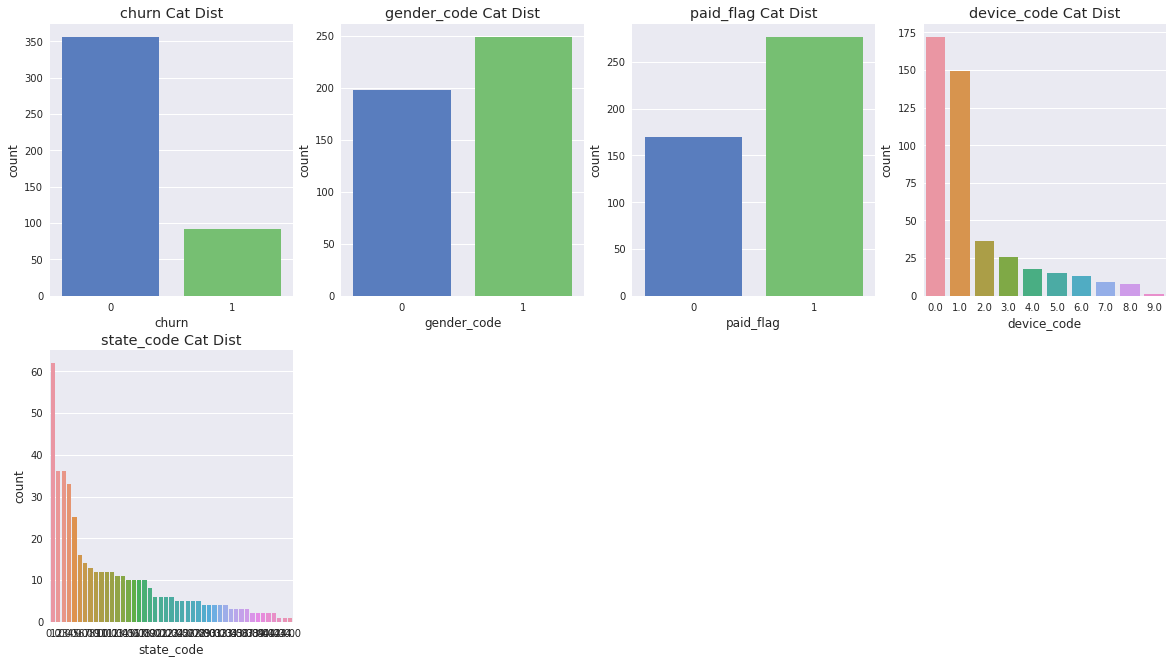

In [22]:
cat_full_cols_list=["churn","gender_code","paid_flag","device_code","state_code"]
assess_dist_for_categorical(features_df,cat_full_cols_list)

## The relationship between independent variable and dependent variable: 
- Draw scatter plot for observation:
 week_active_ratio,month_active_ratio 
avg_songs_per_home,regist_days 
"st_songs_trend","mt_songs_trend","lt_songs_trend" 

Text(0.5,1,'st_songs_trend Distribution')

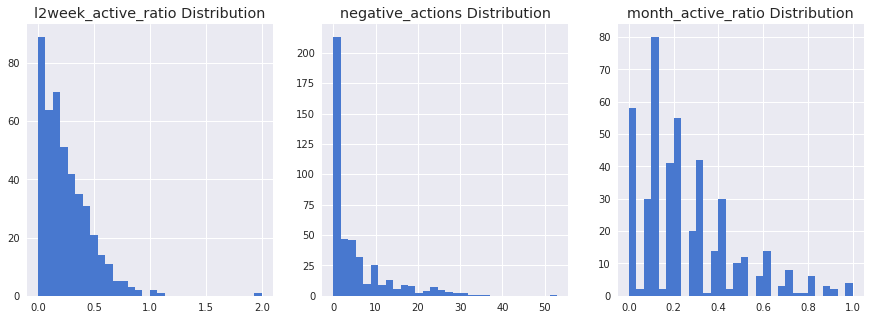

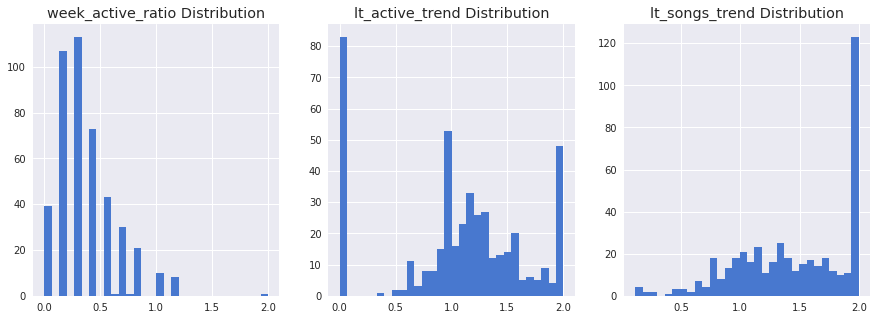

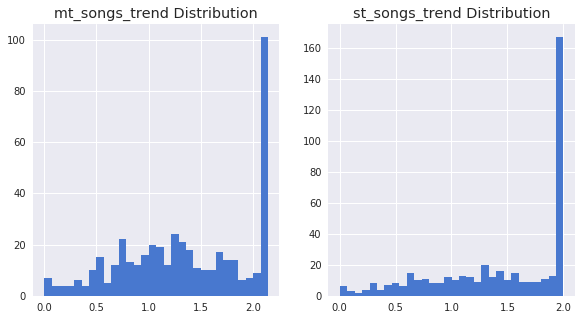

In [23]:
#Feature explore
plt.figure(figsize = (15,5))
plt.subplot(131)
features_df.l2week_active_ratio.hist(bins = 30)
plt.title('l2week_active_ratio Distribution')
plt.subplot(132)
features_df.negative_actions.hist(bins = 30)
plt.title('negative_actions Distribution')
plt.subplot(133)
features_df.month_active_ratio.hist(bins = 30)
plt.title('month_active_ratio Distribution')
plt.figure(figsize = (15,5))
plt.subplot(131)
features_df.week_active_ratio.hist(bins = 30)
plt.title('week_active_ratio Distribution')
plt.subplot(132)
features_df.lt_active_trend.hist(bins = 30)
plt.title('lt_active_trend Distribution')
plt.subplot(133)
features_df.lt_songs_trend.hist(bins = 30)
plt.title('lt_songs_trend Distribution')
plt.figure(figsize = (15,5))
plt.subplot(131)
features_df.mt_songs_trend.hist(bins = 30)
plt.title('mt_songs_trend Distribution')
plt.subplot(132)
features_df.st_songs_trend.hist(bins = 30)
plt.title('st_songs_trend Distribution')

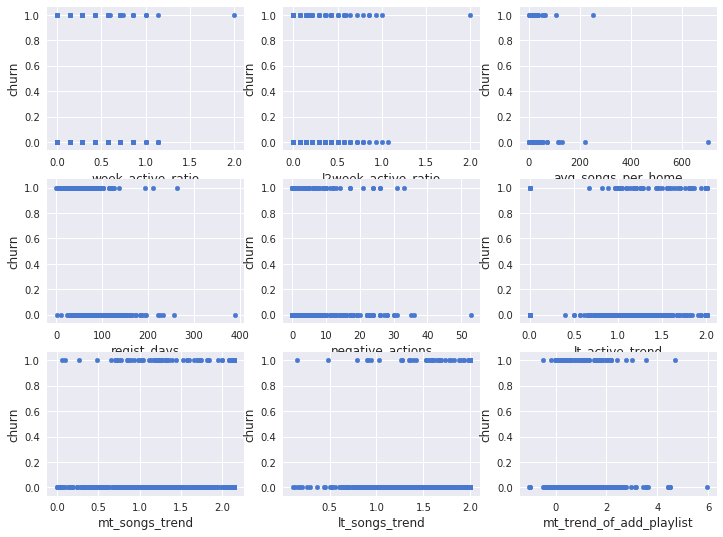

In [24]:
fig,axes = plt.subplots(nrows = 3,ncols = 3, figsize = (12,9))
features_df.plot.scatter(x='week_active_ratio',y='churn',ax=axes[0,0])
features_df.plot.scatter(x='l2week_active_ratio',y='churn',ax=axes[0,1])
features_df.plot.scatter(x='avg_songs_per_home',y='churn',ax=axes[0,2])
features_df.plot.scatter(x='regist_days',y='churn',ax=axes[1,0])
features_df.plot.scatter(x='negative_actions',y='churn',ax=axes[1,1])
features_df.plot.scatter(x='lt_active_trend',y='churn',ax=axes[1,2])
features_df.plot.scatter(x='mt_songs_trend',y='churn',ax=axes[2,0])
features_df.plot.scatter(x='lt_songs_trend',y='churn',ax=axes[2,1])
features_df.plot.scatter(x='mt_trend_of_add_playlist',y='churn',ax=axes[2,2])

In [25]:
def get_cut_countplot(col, base_col,bin, hue='churn', df=features):
    df[col]  = pd.cut(df[base_col],bins = bin)
    tmp = df.groupby(col).user_id.count().sort_values().reset_index()
    tmp['amount_cumsum'] = tmp.user_id.cumsum()
    tmp['prop'] = tmp.apply(lambda x:x.amount_cumsum/df.shape[0],axis =1)
    print(tmp)
    plt.figure(figsize=(12, 5))
    sns.countplot(x = col,hue = hue,data =df)

  negative_actions_label  user_id  amount_cumsum      prop
0               (30, 50]        5              5  0.011186
1               (15, 20]       18             23  0.051454
2               (20, 30]       22             45  0.100671
3                (8, 10]       25             70  0.156600
4                 (6, 8]       26             96  0.214765
5               (10, 15]       28            124  0.277405
6                 (4, 6]       40            164  0.366890
7                 (2, 4]       47            211  0.472036
8                 (0, 2]       68            279  0.624161
   avg_songs_per_home_label  user_id  amount_cumsum      prop
0                    (0, 3]        0              0  0.000000
1                    (3, 5]        0              0  0.000000
2                 (90, 100]        0              0  0.000000
3                  (70, 90]        1              1  0.002237
4                  (50, 70]        7              8  0.017897
5                  (40, 50]       11  

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


   l2week_active_ratio_label  user_id  amount_cumsum      prop
0                (0.0, 0.05]        0              0  0.000000
1                (0.3, 0.35]        0              0  0.000000
2                (0.15, 0.2]        2              2  0.004474
3                 (0.8, 1.0]        7              9  0.020134
4                 (0.5, 0.6]       15             24  0.053691
5                 (0.6, 0.8]       20             44  0.098434
6                (0.35, 0.4]       35             79  0.176734
7                (0.25, 0.3]       42            121  0.270694
8                (0.2, 0.25]       51            172  0.384787
9                 (0.4, 0.5]       52            224  0.501119
10               (0.05, 0.1]       64            288  0.644295
11               (0.1, 0.15]       68            356  0.796421
   week_active_ratio_label  user_id  amount_cumsum      prop
0              (0.0, 0.05]        0              0  0.000000
1              (0.05, 0.1]        0              0  0.00000

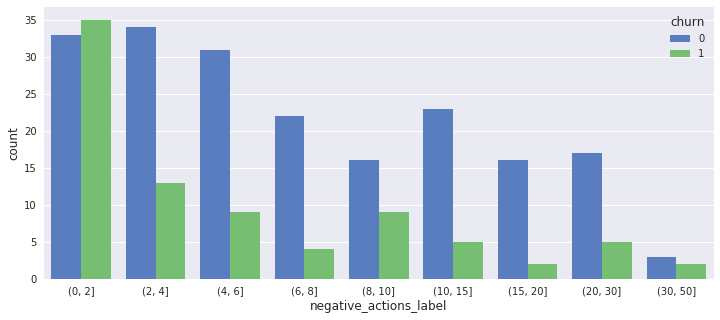

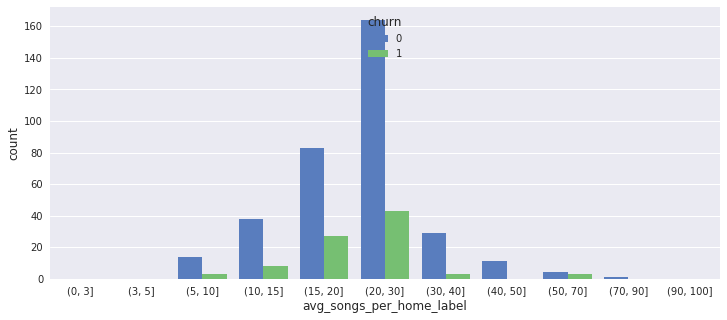

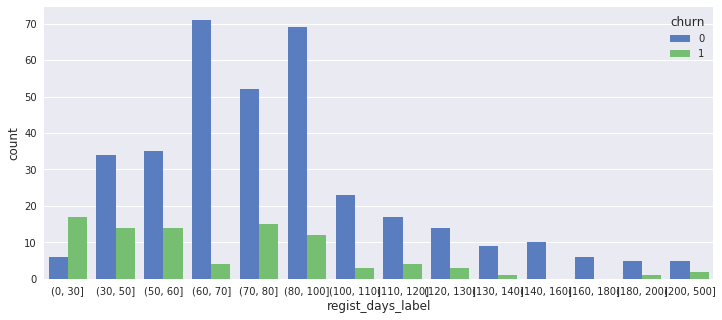

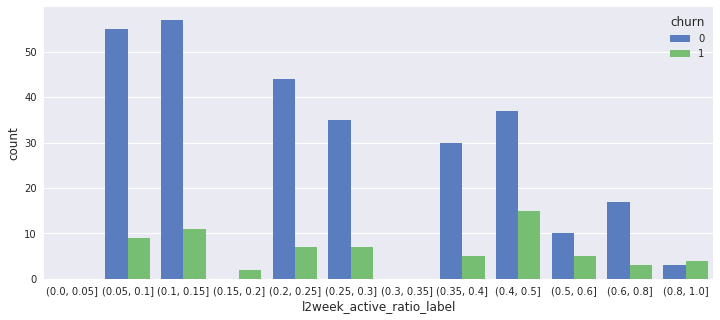

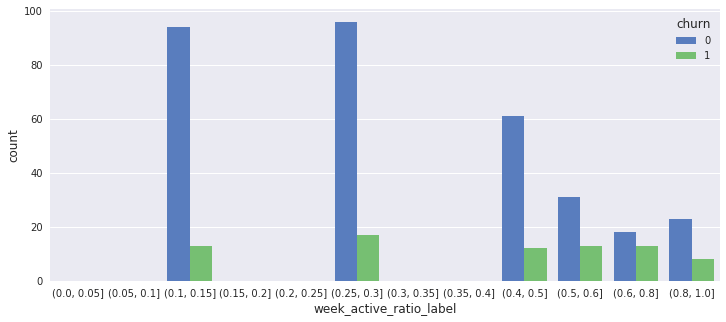

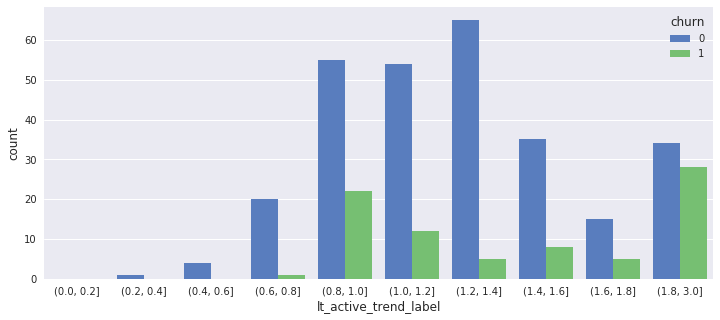

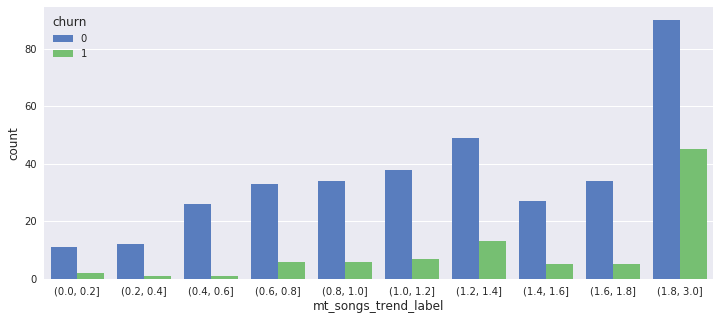

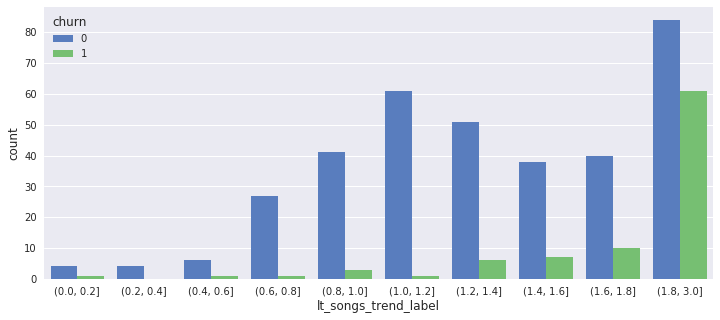

In [26]:
# chech them by bins
tsl_bin = [0,2,4,6,8,10,15,20,30,50]
get_cut_countplot('negative_actions_label','negative_actions',bin=tsl_bin, hue='churn', df=features_df)
asp_bin = [0,3,5,10,15,20,30,40,50,70,90,100]
get_cut_countplot('avg_songs_per_home_label','avg_songs_per_home',bin=asp_bin, hue='churn', df=features_df)
reg_bin = [0,30,50,60,70,80,100,110,120,130,140,160,180,200,500]
get_cut_countplot('regist_days_label','regist_days',bin=reg_bin, hue='churn', df=features_df)
l2r_bin = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.8,1]
get_cut_countplot('l2week_active_ratio_label','l2week_active_ratio',bin=l2r_bin, hue='churn', df=features_df)
war_bin = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.8,1]
get_cut_countplot('week_active_ratio_label','week_active_ratio',bin=war_bin, hue='churn', df=features_df)
sst_bin = [0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,3]
get_cut_countplot('lt_active_trend_label','lt_active_trend',bin=sst_bin, hue='churn', df=features_df)
mmt_bin = [0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,3]
get_cut_countplot('mt_songs_trend_label','mt_songs_trend',bin=mmt_bin, hue='churn', df=features_df)
lmt_bin = [0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,3]
get_cut_countplot('lt_songs_trend_label','lt_songs_trend',bin=lmt_bin, hue='churn', df=features_df)

## analysis
- regist_days: easy to churn if the registration duration is less than 60 days
- avg_songs_per_home: people who listen to fewer than 10 songs per visit to the home page are more likely to churn.
- Total_song_amount: easy to churn after listening to 400~500 songs
- "st_songs_trend","mt_songs_trend","lt_songs_trend": high churn rate between 1.8 and 3

Finally, the correlation between variables was observed through the correlation matrix of heapmap:

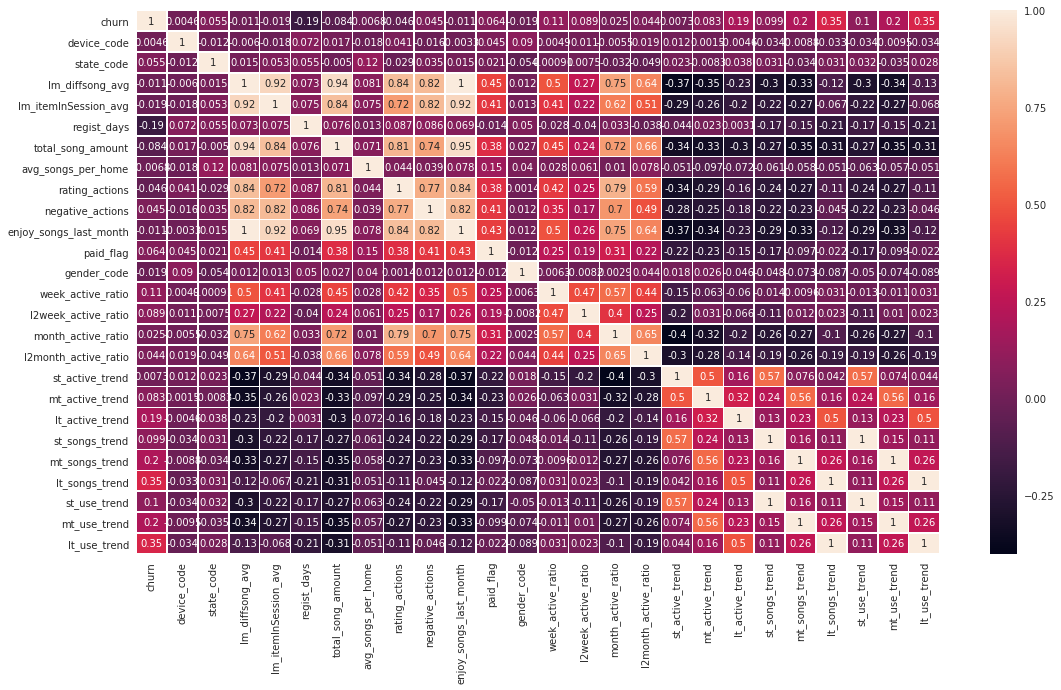

In [27]:
#heatmap plot for varriables correlation
internal_chars=["churn","device_code","state_code","lm_diffsong_avg","lm_itemInSession_avg",
                "regist_days","total_song_amount","avg_songs_per_home","rating_actions",
               "negative_actions","enjoy_songs_last_month","paid_flag","gender_code",
                "week_active_ratio","l2week_active_ratio","month_active_ratio","l2month_active_ratio",
                "st_active_trend","mt_active_trend","lt_active_trend",
                "st_songs_trend","mt_songs_trend","lt_songs_trend",
               "st_use_trend","mt_use_trend","lt_use_trend"]
corrmat = features_df[internal_chars].corr()
f, ax = plt.subplots(figsize=(18, 10))
plt.xticks(rotation='0')
sns.heatmap(corrmat, square=False, linewidths=.5, annot=True)

## Analysis:
 - "st_use_trend","mt_use_trend","lt_use_trend" are highly correlated with "st_songs_trend","mt_songs_trend","lt_songs_trend",so remove "st_use_trend","mt_use_trend","lt_use_trend". 
 - Lm_artist_avg is highly correlated with enjoy_songs_last_month, lm_diffsong_avg, so remove Lm_artist_avg.
 - enjoy_songs_last_month is  highly correlated with lm_diffsong_avg, so remove enjoy_songs_last_month.
 - "lm_diffsong_avg" is  highly correlated with "rating_actions",so remove "lm_diffsong_avg" 

In [28]:
def show_heapmap(features_df,fea_chars,fig_size=(10, 8)):
    corrmat = features_df[fea_chars].corr()
    plt.figure(figsize=fig_size)
    plt.xticks(rotation='0')
    sns.heatmap(corrmat, square=False, linewidths=.5, annot=True)

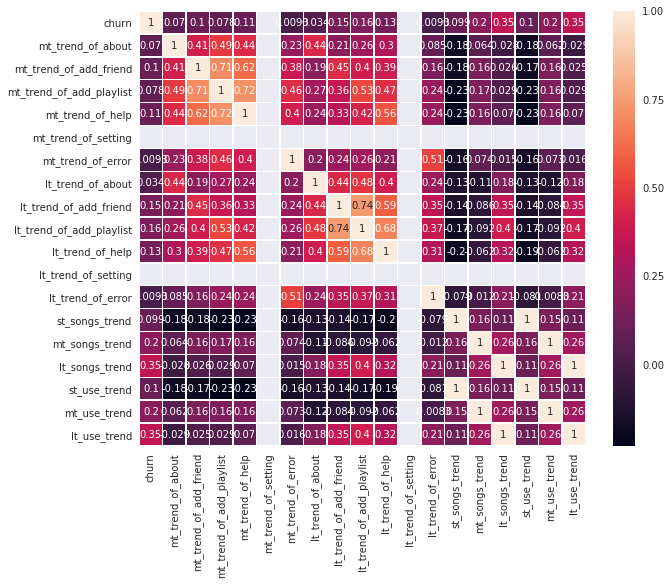

In [29]:
fea_chars=["churn",
           "mt_trend_of_about","mt_trend_of_add_friend","mt_trend_of_add_playlist",
           "mt_trend_of_help","mt_trend_of_setting","mt_trend_of_error",      
           "lt_trend_of_about","lt_trend_of_add_friend","lt_trend_of_add_playlist",
           "lt_trend_of_help","lt_trend_of_setting","lt_trend_of_error",
           "st_songs_trend","mt_songs_trend","lt_songs_trend",
               "st_use_trend","mt_use_trend","lt_use_trend"]
show_heapmap(features_df,fea_chars)

## Analysis
According to above heatmap graphs and the correlation between features and churn, the following features are listed:
 - mt_trend_of_add_friend
 - mt_trend_of_add_playlist
 - mt_trend_of_help
 - lt_trend_of_add_friend
 - lt_trend_of_add_playlist
 - lt_trend_of_help
 - mt_songs_trend
 - lt_songs_trend
 - lt_active_trend
 - mt_active_trend
 - state_code
 - regist_days
 - total_song_amount

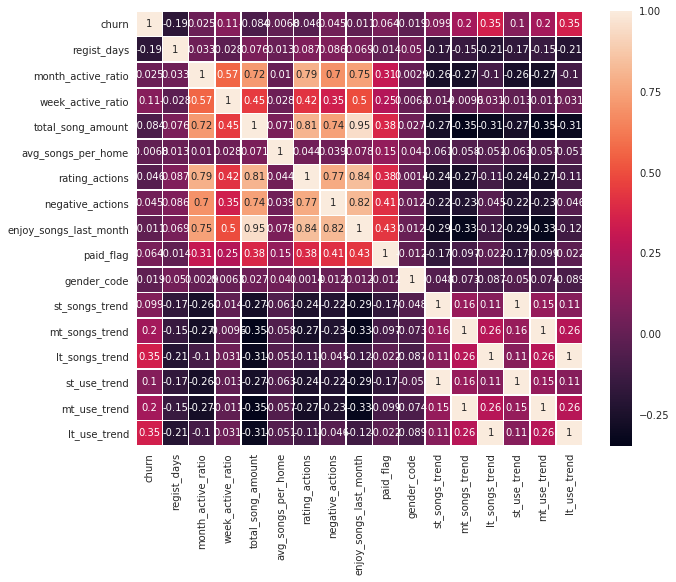

In [30]:
#select fea_chars

fea_chars=["churn","regist_days","month_active_ratio","week_active_ratio",
               "total_song_amount","avg_songs_per_home","rating_actions","negative_actions",
               "enjoy_songs_last_month","paid_flag","gender_code","st_songs_trend","mt_songs_trend","lt_songs_trend",
               "st_use_trend","mt_use_trend","lt_use_trend"]
show_heapmap(features_df,fea_chars)

# Modeling
 
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [31]:
def create_train_test(data,retain_len,churn_len,split_ratio=[0.7,0.3]):
    """
    Description: 
        Because churn data is imbalance, churn users is few.
        we should do stratified sampling. the reasonal retain to churn  ratio is 70~80:30~20
    Args:
      data: input dataframe of features
      retain_len: retain records amount
      churn_len: churn records amount
      split_ratio:[training: test] train to test ratio and it also retain to churn ratio([retain:churn]).
    Return:
      trainingData: training dataset
      testData: test dataset
    """
    #stratrified sampling on churn and retain users.
    retain2churn=split_ratio[0]/split_ratio[1]
    churn_broken_retain=(retain2churn*churn_len>retain_len)
    if not churn_broken_retain:
        select_retain_len = int(retain2churn*churn_len)
        select_churn_len = churn_len 
    else:
        select_retain_len= retain_len 
        select_churn_len = int(retain_len/retain2churn)
    print("select retain number:{} select churn number:{}".format(select_retain_len,select_churn_len))
    
    #stratrified sampling on training and test dataset.
    #Get Churn rows base on split ratio  and split it to trainning and test dataset.
    train_churn_data,test_churn_data=data.filter(data.label==1).limit(select_churn_len )\
        .randomSplit(split_ratio,seed=1234)
    train_retain_data,test_retain_data=data.filter(data.label==0).limit(select_retain_len)\
        .randomSplit(split_ratio,seed=1234)
    
    print(train_churn_data.count(),test_churn_data.count())
    print(train_retain_data.count(),test_retain_data.count())
    # union churn and retain data and shuffle them
    trainingData=train_churn_data.union(train_retain_data).orderBy(rand())
    testData=test_churn_data.union(test_retain_data).orderBy(rand())
    return trainingData,testData

In [32]:
#Model Evaluation and Validation
def display_score(predictions):

    # Evaluate model accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    # caculate score
    accuracy_score = evaluator.setMetricName('accuracy').evaluate(predictions)
    f1_score = evaluator.setMetricName('f1').evaluate(predictions)
    Precision_score = evaluator.setMetricName('weightedPrecision').evaluate(predictions)
    Recall_score = evaluator.setMetricName('weightedRecall').evaluate(predictions)
    print("accuracy: {:.2%}, Precision: {:.2%}, Recall: {:.2%}, F1 Score: {:.2%}".\
          format(accuracy_score,Precision_score,Recall_score,f1_score))

In [34]:
def model_selection(training, test):
    # Configure an ML pipeline, which consists of tree stages: rf   
    scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
    rf = RandomForestClassifier(featuresCol="scaledFeatures",maxDepth=4)
    pipeline = Pipeline(stages=[scaler,rf])
    
    # We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
    # This will allow us to jointly choose parameters for all Pipeline stages.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
    # this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [100])\
        .addGrid(rf.maxDepth, [4])\
        .addGrid(rf.minInstancesPerNode, [1,5]) \
        .build()
  
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator= MulticlassClassificationEvaluator(metricName='f1'),
                              numFolds=3)  # use 3+ folds in practice

    # Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(training)
    
    # Fetch best model
    best_model = cvModel.bestModel#.stages[1]
    print(best_model)
    print(cvModel)
    display_score(cvModel.transform(training))
    # Make predictions on test documents. cvModel uses the best model found (lrModel).
    prediction = cvModel.transform(test)
    #predict_b = best_model.transform(test)
    return prediction,  best_model,cvModel,crossval

In [35]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
def model_selection_two(training, test):
    # Configure an ML pipeline, which consists of tree stages: rf   
    scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
    lr= LogisticRegression(featuresCol="scaledFeatures")
    pipeline = Pipeline(stages=[scaler,lr])
    
    # We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
    # This will allow us to jointly choose parameters for all Pipeline stages.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
    # this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
    #MulticlassClassificationEvaluator(metricName='f1')
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.1,0.3])\
        .addGrid(lr.family,["multinomial"]) \
        .build()
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                              numFolds=3) 

    # Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(training)
    
    # Fetch best model
    best_model = cvModel.bestModel#.stages[1]
    #print(cvModel.bestModel.getParamMap() )
    # Make predictions on test documents. cvModel uses the best model found (lrModel).
    display_score(cvModel.transform(training))
    prediction = cvModel.transform(test)
    #predict_b = best_model.transform(test)
    return prediction, best_model,cvModel,crossval

In [36]:

from pyspark.ml.classification  import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
def model_selection_three(training, test):
    # Configure an ML pipeline, which consists of tree stages: rf   
    scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
    gbt = GBTClassifier(featuresCol="scaledFeatures",maxDepth=5,maxIter=10,seed=42)
    pipeline = Pipeline(stages=[scaler,gbt])
    
    # We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
    # This will allow us to jointly choose parameters for all Pipeline stages.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
    # this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
    #MulticlassClassificationEvaluator(metricName='f1')
    paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .build()
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                              numFolds=3) 

    # Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(training)
    
    # Fetch best model
    best_model = cvModel.bestModel#.stages[1]
    #print(cvModel.bestModel.getParamMap() )
    # Make predictions on test documents. cvModel uses the best model found (lrModel).
    display_score(cvModel.transform(training))
    prediction = cvModel.transform(test)
    #predict_b = best_model.transform(test)
    return prediction, best_model,cvModel,crossval

In [37]:
def verify_feat_cols_change(data,best_model,retain_len,churn_len,split_ratio):
    print("split ratio:{}".format(split_ratio))
    trainingData, testData  = create_train_test(data,retain_len,churn_len,split_ratio=split_ratio)
    predictions = best_model.transform(testData)
    #%time display_score(predictions.filter('label = 1'))
    #%time display_score(predictions.filter('label = 0'))
    %time display_score(predictions)
    %time show_score(predictions)
    confuse_matrix(predictions)

In [39]:
def show_importances(feature,importances):
    Feature_weight=dict(zip(feature,importances))
    sorted_weight=sorted(list(Feature_weight.items()),key=lambda x:x[1], reverse=False)
    importances=[w[1] for w in sorted_weight]
    feature=[w[0] for w in sorted_weight]
    y_pos = np.arange(len(feature))
    plt.figure(figsize=(5,4))
    plt.barh(y_pos, importances, align='center', alpha=0.5)
    plt.yticks(y_pos, feature)
    plt.xlabel('Importance Score')
    plt.title('Feature Importances')
    plt.show()
    print(feature)

# Feature selection
## 1st Round

feature columns:['churn', 'mt_trend_of_add_friend', 'mt_trend_of_add_playlist', 'mt_trend_of_help', 'mt_trend_of_error', 'lt_trend_of_add_friend', 'lt_trend_of_add_playlist', 'lt_trend_of_help', 'mt_songs_trend', 'lt_songs_trend', 'lt_active_trend', 'mt_active_trend', 'state_code', 'regist_days', 'total_song_amount']
split ratio:[0.8, 0.2]
select retain number:355 select churn number:88
73 15
297 58
PipelineModel_4f42aa8fe5fb89fc62b4
CrossValidatorModel_43f0aeb8c6476e5a0881
accuracy: 89.73%, Precision: 90.55%, Recall: 89.73%, F1 Score: 88.34%
CPU times: user 11.5 s, sys: 3.33 s, total: 14.9 s
Wall time: 17min 48s
accuracy: 87.67%, Precision: 87.65%, Recall: 87.67%, F1 Score: 86.15%
CPU times: user 552 ms, sys: 148 ms, total: 700 ms
Wall time: 44.6 s
label       1   0
prediction       
1.0         7   1
0.0         8  57


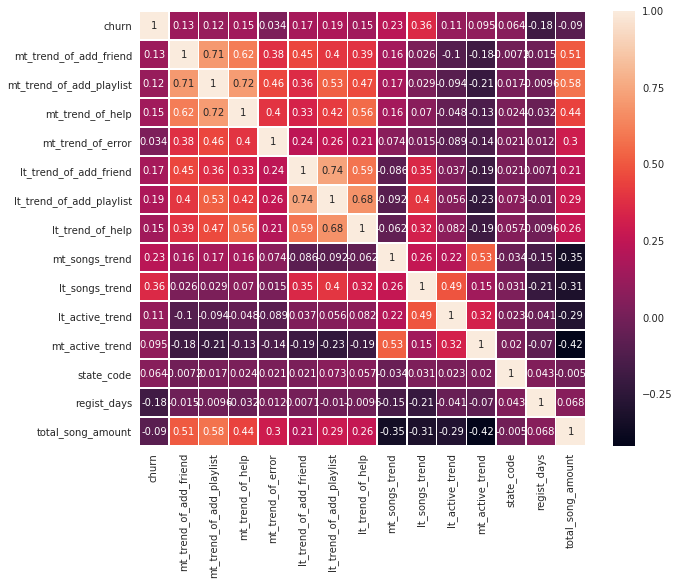

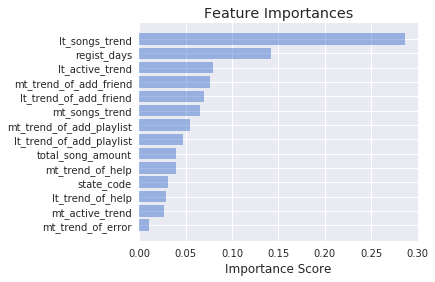

['mt_trend_of_error', 'mt_active_trend', 'lt_trend_of_help', 'state_code', 'mt_trend_of_help', 'total_song_amount', 'lt_trend_of_add_playlist', 'mt_trend_of_add_playlist', 'mt_songs_trend', 'lt_trend_of_add_friend', 'mt_trend_of_add_friend', 'lt_active_trend', 'regist_days', 'lt_songs_trend']


In [39]:
#--------------------------------------------------------------
# Select 1st feature sets
#-------------------------------------------------------------- 
fea_chars=["churn","mt_trend_of_add_friend","mt_trend_of_add_playlist","mt_trend_of_help",
           "mt_trend_of_error","lt_trend_of_add_friend","lt_trend_of_add_playlist",
           "lt_trend_of_help","mt_songs_trend","lt_songs_trend","lt_active_trend",
           "mt_active_trend","state_code","regist_days","total_song_amount"]
#--------------------------------------------------------------  
# show heatmap figure
#--------------------------------------------------------------  
print("feature columns:{}".format(fea_chars))
show_heapmap(features_df,fea_chars)

#--------------------------------------------------------------  
# Sample data and build training and test dataset
#--------------------------------------------------------------  
split_ratio=[0.8,0.2]
print("split ratio:{}".format(split_ratio))

#remove old data
features=features.drop('FeaturesVec')
# transform features to model input format  
feature=fea_chars[1:]
assembler = VectorAssembler(inputCols=feature, outputCol="FeaturesVec")
features = assembler.transform(features)
# specifies the input column names of the input label and features based on the needs of the model
data = features.select(features.churn.alias("label"), features.FeaturesVec.alias("features"))
data.cache()
# analysis churn records
#The following steps take a long time to calculate
retain_len,churn_len=features_df['churn'].value_counts().values.tolist()
trainingData, testData  = create_train_test(data,retain_len,churn_len,split_ratio)
trainingData.cache()
testData.cache()
#--------------------------------------------------------------  
# model: RandomForestDecisionClassificator
#--------------------------------------------------------------  
%time predictions , best_model,cvModel,crossval= model_selection(trainingData, testData)
print("Test dataset score:")
%time display_score(predictions)
#--------------------------------------------------------------  
# Show feature Importances
#--------------------------------------------------------------  
importances=best_model.stages[1].featureImportances.values.tolist()
show_importances(feature,importances)


## 2nd Round

feature columns:['churn', 'regist_days', 'month_active_ratio', 'week_active_ratio', 'total_song_amount', 'avg_songs_per_home', 'rating_actions', 'negative_actions', 'enjoy_songs_last_month', 'paid_flag', 'gender_code', 'st_songs_trend', 'mt_songs_trend', 'lt_songs_trend', 'st_use_trend', 'mt_use_trend', 'lt_use_trend']
split ratio:[0.8, 0.2]
select retain number:355 select churn number:88
73 15
297 58
PipelineModel_4efa974695d4c6bbcb39
CrossValidatorModel_455d8bcb3f8f84d78dde
accuracy: 90.27%, Precision: 90.20%, Recall: 90.27%, F1 Score: 89.42%
CPU times: user 11.9 s, sys: 3.51 s, total: 15.4 s
Wall time: 17min 28s
accuracy: 90.41%, Precision: 90.06%, Recall: 90.41%, F1 Score: 90.00%
CPU times: user 572 ms, sys: 180 ms, total: 752 ms
Wall time: 44 s
label        1   0
prediction        
1.0         10   2
0.0          5  56


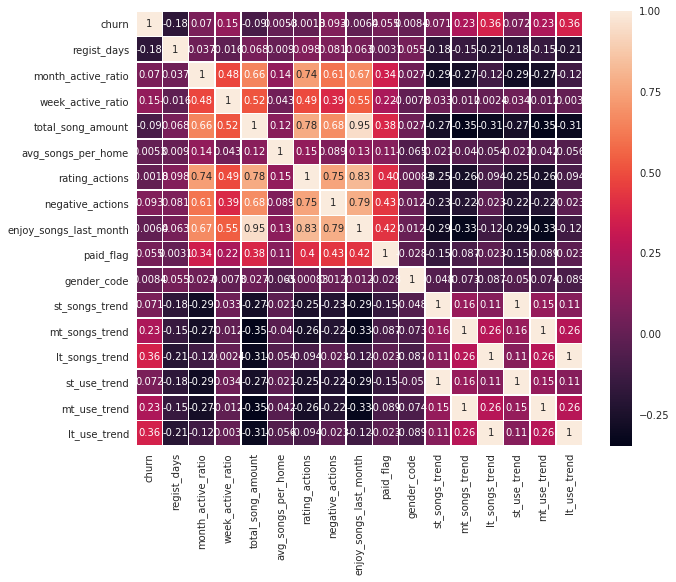

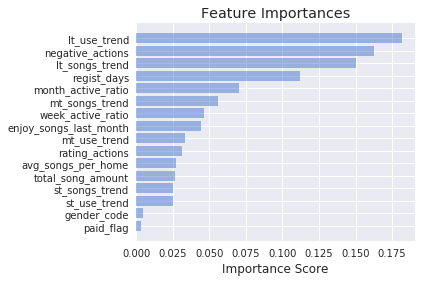

['paid_flag', 'gender_code', 'st_use_trend', 'st_songs_trend', 'total_song_amount', 'avg_songs_per_home', 'rating_actions', 'mt_use_trend', 'enjoy_songs_last_month', 'week_active_ratio', 'mt_songs_trend', 'month_active_ratio', 'regist_days', 'lt_songs_trend', 'negative_actions', 'lt_use_trend']


In [40]:
#--------------------------------------------------------------
# Select 2nd feature sets
#-------------------------------------------------------------- 
fea_chars=["churn","regist_days","month_active_ratio","week_active_ratio",
               "total_song_amount","avg_songs_per_home","rating_actions","negative_actions",
               "enjoy_songs_last_month","paid_flag","gender_code","st_songs_trend","mt_songs_trend","lt_songs_trend",
               "st_use_trend","mt_use_trend","lt_use_trend"]
#--------------------------------------------------------------  
# show heatmap figure
#--------------------------------------------------------------  
print("feature columns:{}".format(fea_chars))
show_heapmap(features_df,fea_chars)

#--------------------------------------------------------------  
# Sample data and build training and test dataset
#--------------------------------------------------------------  
split_ratio=[0.8,0.2]
print("split ratio:{}".format(split_ratio))

#remove old data
features=features.drop('FeaturesVec')
# transform features to model input format  
feature=fea_chars[1:]
assembler = VectorAssembler(inputCols=feature, outputCol="FeaturesVec")
features = assembler.transform(features)
# specifies the input column names of the input label and features based on the needs of the model
data = features.select(features.churn.alias("label"), features.FeaturesVec.alias("features"))
data.cache()
# analysis churn records
#The following steps take a long time to calculate
retain_len,churn_len=features_df['churn'].value_counts().values.tolist()
trainingData, testData  = create_train_test(data,retain_len,churn_len,split_ratio)
trainingData.cache()
testData.cache()
#--------------------------------------------------------------  
# model: RandomForestDecisionClassificator
#--------------------------------------------------------------  
%time predictions , best_model,cvModel,crossval= model_selection(trainingData, testData)
print("Test dataset score:")
%time display_score(predictions)
#--------------------------------------------------------------  
# Show feature Importances
#--------------------------------------------------------------  
importances=best_model.stages[1].featureImportances.values.tolist()
show_importances(feature,importances)


## 3rd Round

feature columns:['churn', 'regist_days', 'month_active_ratio', 'week_active_ratio', 'state_code', 'device_code', 'total_song_amount', 'avg_songs_per_home', 'rating_actions', 'negative_actions', 'enjoy_songs_last_month', 'paid_flag', 'gender_code', 'st_songs_trend', 'mt_songs_trend', 'lt_songs_trend']
split ratio:[0.8, 0.2]
select retain number:356 select churn number:89
73 16
298 58
PipelineModel_4f21aceeaa5f5dc08ea5
CrossValidatorModel_4d859c2b4c0ed7d5b996
accuracy: 88.95%, Precision: 89.28%, Recall: 88.95%, F1 Score: 87.51%
CPU times: user 12 s, sys: 3.16 s, total: 15.1 s
Wall time: 15min 1s
Test dataset score:
accuracy: 87.84%, Precision: 89.47%, Recall: 87.84%, F1 Score: 85.90%
CPU times: user 572 ms, sys: 152 ms, total: 724 ms
Wall time: 35.3 s


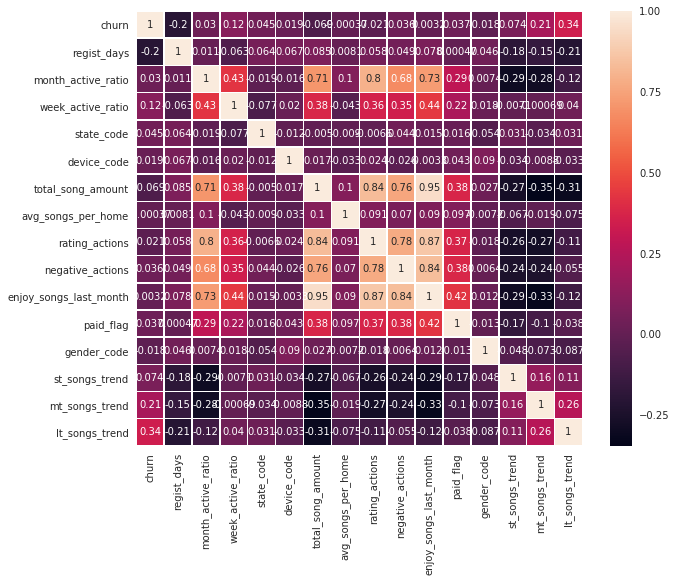

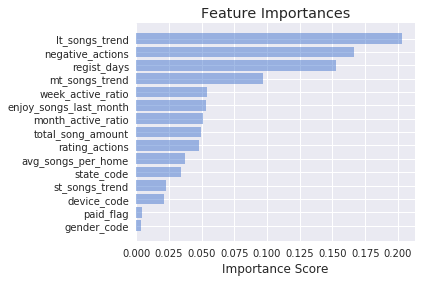

['gender_code', 'paid_flag', 'device_code', 'st_songs_trend', 'state_code', 'avg_songs_per_home', 'rating_actions', 'total_song_amount', 'month_active_ratio', 'enjoy_songs_last_month', 'week_active_ratio', 'mt_songs_trend', 'regist_days', 'negative_actions', 'lt_songs_trend']


In [40]:
#--------------------------------------------------------------
# Select 2nd feature sets
#-------------------------------------------------------------- 
fea_chars=["churn","regist_days","month_active_ratio","week_active_ratio","state_code","device_code",
               "total_song_amount","avg_songs_per_home","rating_actions","negative_actions",
               "enjoy_songs_last_month","paid_flag","gender_code","st_songs_trend","mt_songs_trend","lt_songs_trend"]
#--------------------------------------------------------------  
# show heatmap figure
#--------------------------------------------------------------  
print("feature columns:{}".format(fea_chars))
show_heapmap(features_df,fea_chars)

#--------------------------------------------------------------  
# Sample data and build training and test dataset
#--------------------------------------------------------------  
split_ratio=[0.8,0.2]
print("split ratio:{}".format(split_ratio))

#remove old data
features=features.drop('FeaturesVec')
# transform features to model input format  
feature=fea_chars[1:]
assembler = VectorAssembler(inputCols=feature, outputCol="FeaturesVec")
features = assembler.transform(features)
# specifies the input column names of the input label and features based on the needs of the model
data = features.select(features.churn.alias("label"), features.FeaturesVec.alias("features"))
data.cache()
# analysis churn records
#The following steps take a long time to calculate
retain_len,churn_len=features_df['churn'].value_counts().values.tolist()
trainingData, testData  = create_train_test(data,retain_len,churn_len,split_ratio)
trainingData.cache()
testData.cache()
#--------------------------------------------------------------  
# model: RandomForestDecisionClassificator
#--------------------------------------------------------------  
%time predictions , best_model,cvModel,crossval= model_selection(trainingData, testData)
print("Test dataset score:")
%time display_score(predictions)
#--------------------------------------------------------------  
# Show feature Importances
#--------------------------------------------------------------  
importances=best_model.stages[1].featureImportances.values.tolist()
show_importances(feature,importances)


## 4th Round

feature columns:['churn', 'state_code', 'regist_days', 'l2week_active_ratio', 'week_active_ratio', 'total_song_amount', 'avg_songs_per_home', 'rating_actions', 'paid_flag', 'negative_actions', 'gender_code', 'mt_active_trend', 'lt_active_trend', 'mt_songs_trend', 'lt_songs_trend']
split ratio:[0.8, 0.2]
select retain number:356 select churn number:89
73 16
298 58
PipelineModel_4cd6aea39a5b552afa90
CrossValidatorModel_43a3b4abe33743027d33
accuracy: 92.72%, Precision: 93.12%, Recall: 92.72%, F1 Score: 92.12%
CPU times: user 12.5 s, sys: 3.05 s, total: 15.6 s
Wall time: 15min 38s
Test dataset score:
accuracy: 82.43%, Precision: 82.04%, Recall: 82.43%, F1 Score: 78.59%
CPU times: user 576 ms, sys: 152 ms, total: 728 ms
Wall time: 34.4 s


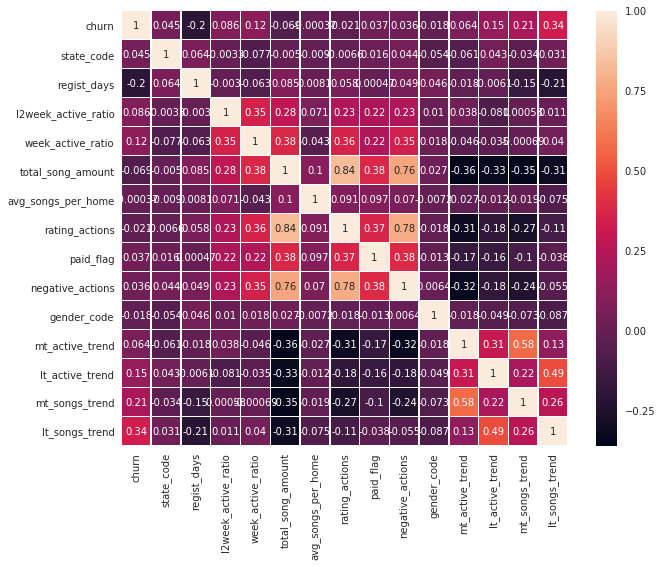

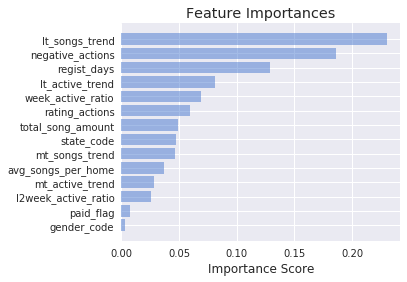

['gender_code', 'paid_flag', 'l2week_active_ratio', 'mt_active_trend', 'avg_songs_per_home', 'mt_songs_trend', 'state_code', 'total_song_amount', 'rating_actions', 'week_active_ratio', 'lt_active_trend', 'regist_days', 'negative_actions', 'lt_songs_trend']


In [41]:
#--------------------------------------------------------------
# Select 4th feature sets
#-------------------------------------------------------------- 
fea_chars=["churn","state_code","regist_days", 'l2week_active_ratio','week_active_ratio',"total_song_amount","avg_songs_per_home",  
                "rating_actions","paid_flag","negative_actions","gender_code","mt_active_trend", 
                "lt_active_trend","mt_songs_trend","lt_songs_trend"]
#--------------------------------------------------------------  
# show heatmap figure
#--------------------------------------------------------------  
print("feature columns:{}".format(fea_chars))
show_heapmap(features_df,fea_chars)

#--------------------------------------------------------------  
# Sample data and build training and test dataset
#--------------------------------------------------------------  
split_ratio=[0.8,0.2]
print("split ratio:{}".format(split_ratio))

#remove old data
features=features.drop('FeaturesVec')
# transform features to model input format  
feature=fea_chars[1:]
assembler = VectorAssembler(inputCols=feature, outputCol="FeaturesVec")
features = assembler.transform(features)
# specifies the input column names of the input label and features based on the needs of the model
data = features.select(features.churn.alias("label"), features.FeaturesVec.alias("features"))
data.cache()
# analysis churn records
#The following steps take a long time to calculate
retain_len,churn_len=features_df['churn'].value_counts().values.tolist()
trainingData, testData  = create_train_test(data,retain_len,churn_len,split_ratio)
trainingData.cache()
testData.cache()
#--------------------------------------------------------------  
# model: RandomForestDecisionClassificator
#--------------------------------------------------------------  
%time predictions , best_model,cvModel,crossval= model_selection(trainingData, testData)
print("Test dataset score:")
%time display_score(predictions)
#--------------------------------------------------------------  
# Show feature Importances
#--------------------------------------------------------------  
importances=best_model.stages[1].featureImportances.values.tolist()
show_importances(feature,importances)
          

# Evaluate Model

feature columns:['churn', 'negative_actions', 'avg_songs_per_home', 'l2week_active_ratio', 'week_active_ratio', 'mt_trend_of_add_playlist', 'mt_songs_trend', 'lt_active_trend', 'regist_days', 'lt_songs_trend']
split ratio:[0.8, 0.2]
select retain number:354 select churn number:88
73 15
296 58
accuracy: 95.39%, Precision: 97.02%, Recall: 95.39%, F1 Score: 95.22%
CPU times: user 1min 23s, sys: 21.6 s, total: 1min 44s
Wall time: 1h 24min 53s
Test dataset score:
accuracy: 84.93%, Precision: 87.40%, Recall: 84.93%, F1 Score: 84.28%
CPU times: user 560 ms, sys: 156 ms, total: 716 ms
Wall time: 36.2 s


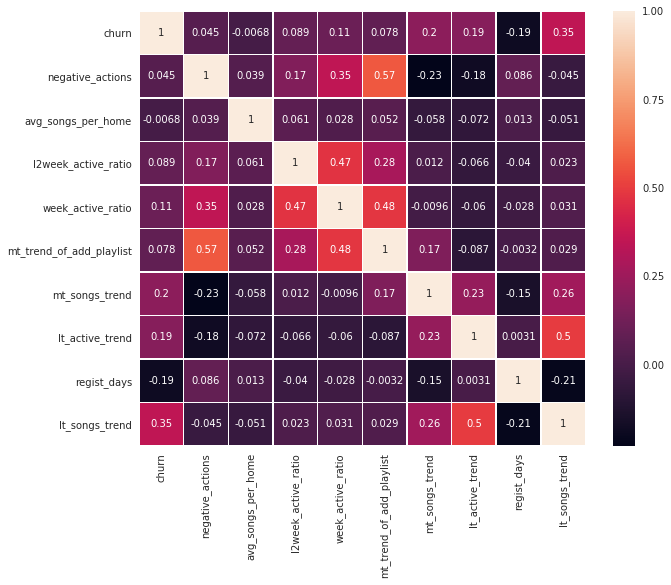

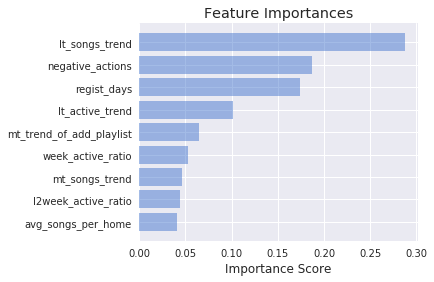

['avg_songs_per_home', 'l2week_active_ratio', 'mt_songs_trend', 'week_active_ratio', 'mt_trend_of_add_playlist', 'lt_active_trend', 'regist_days', 'negative_actions', 'lt_songs_trend']
[{Param(parent='GBTClassifier_4e6f90cf6bbdb193140e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5}, {Param(parent='GBTClassifier_4e6f90cf6bbdb193140e', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10}]
split ratio:[0.8, 0.2]
select retain number:354 select churn number:88
73 15
296 58
accuracy: 80.22%, Precision: 79.28%, Recall: 81.03%, F1 Score: 74.16%
CPU times: user 25.8 s, sys: 6.44 s, total: 32.3 s
Wall time: 31min 51s
Test dataset score:
accuracy: 79.45%, Precision: 62.67%, Recall: 76.71%, F1 Score: 74.39%
CPU times: user 620 ms, sys: 116 ms, total: 736 ms
Wall time: 35.6 s


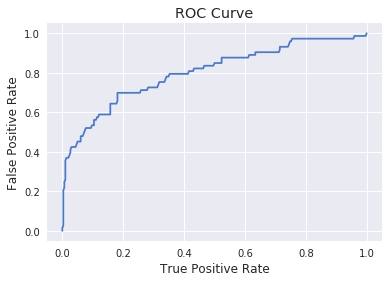

Training set areaUnderROC: 0.8013238944561922
[{Param(parent='LogisticRegression_43f7b951c67a6ff067f7', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'multinomial', Param(parent='LogisticRegression_43f7b951c67a6ff067f7', name='regParam', doc='regularization parameter (>= 0).'): 0.1}, {Param(parent='LogisticRegression_43f7b951c67a6ff067f7', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'multinomial', Param(parent='LogisticRegression_43f7b951c67a6ff067f7', name='regParam', doc='regularization parameter (>= 0).'): 0.3}]
split ratio:[0.8, 0.2]
select retain number:354 select churn number:88
73 15
296 58
PipelineModel_450aaa3e475edeb49945
CrossValidatorModel_4c08959e2ee06c47185d
accuracy: 90.24%, Precision: 89.84%, Recall: 90.79%, F1 Score: 90.40%
CPU times: us

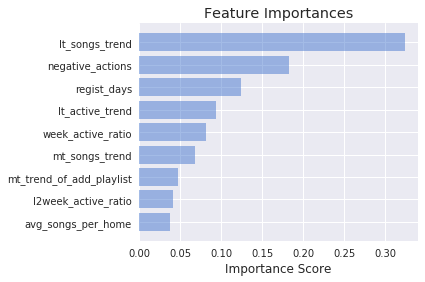

['avg_songs_per_home', 'l2week_active_ratio', 'mt_trend_of_add_playlist', 'mt_songs_trend', 'week_active_ratio', 'lt_active_trend', 'regist_days', 'negative_actions', 'lt_songs_trend']
[{Param(parent='RandomForestClassifier_47fabce8e98e2f95cf1a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4, Param(parent='RandomForestClassifier_47fabce8e98e2f95cf1a', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='RandomForestClassifier_47fabce8e98e2f95cf1a', name='numTrees', doc='Number of trees to train (>= 1).'): 100}, {Param(parent='RandomForestClassifier_47fabce8e98e2f95cf1a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf 

In [40]:
#------------------------------- 
# Final features 
# model: RandomForestDecisionClassificator,LinearRegression,GBTClassifier
#------------------------------- 
fea_chars=['churn','negative_actions','avg_songs_per_home', 'l2week_active_ratio','week_active_ratio', 
           'mt_trend_of_add_playlist', 'mt_songs_trend', 'lt_active_trend', 'regist_days', 'lt_songs_trend']

# explore features
print("feature columns:{}".format(fea_chars))
show_heapmap(features_df,fea_chars)

# build the training and test dataset
# Train the model and predit it 
features=features.drop('FeaturesVec')
# transform features to model input format  
feature=fea_chars[1:]
assembler = VectorAssembler(inputCols=feature, outputCol="FeaturesVec")
features = assembler.transform(features)
# specifies the input column names of the input label and features based on the needs of the model
data = features.select(features.churn.alias("label"), features.FeaturesVec.alias("features"))
data.cache()
#------------------------------- 
# model: GBTClassifier
#------------------------------- 
split_ratio=[0.8,0.2]
print("split ratio:{}".format(split_ratio))
# analysis churn records
#The following steps take a long time to calculate
retain_len,churn_len=features_df['churn'].value_counts().values.tolist()
trainingData, testData  = create_train_test(data,retain_len,churn_len,split_ratio)
trainingData.cache()
testData.cache()
#train and predict
%time predictions , best_model,cvModel3,crossval= model_selection_three(trainingData, testData)
print("Test dataset score:")
%time display_score(predictions)

# draw feature Importances
importances=best_model.stages[1].featureImportances.values.tolist()
show_importances(feature,importances)
print(cvModel3.getEstimatorParamMaps())

#------------------------------- 
# model: LinearRegression
#------------------------------- 
split_ratio=[0.8,0.2]
print("split ratio:{}".format(split_ratio))
# analysis churn records
#The following steps take a long time to calculate
retain_len,churn_len=features_df['churn'].value_counts().values.tolist()
trainingData, testData  = create_train_test(data,retain_len,churn_len,split_ratio)
trainingData.cache()
testData.cache()
#train and predict
%time predictions , best_model,cvModel2,crossval= model_selection_two(trainingData, testData)
print("Test dataset score:")
%time display_score(predictions)

trainingSummary = best_model.stages[1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
print(cvModel2.getEstimatorParamMaps())          
#------------------------------- 
# model: RandomForestDecisionClassificator
#------------------------------- 
split_ratio=[0.8,0.2]
print("split ratio:{}".format(split_ratio))
# analysis churn records
#The following steps take a long time to calculate
retain_len,churn_len=features_df['churn'].value_counts().values.tolist()
trainingData, testData  = create_train_test(data,retain_len,churn_len,split_ratio)
trainingData.cache()
testData.cache()
#train and predict
%time predictions , best_model,cvModel1,crossval= model_selection(trainingData, testData)
print("Test dataset score:")
%time display_score(predictions)

# draw feature Importances
importances=best_model.stages[1].featureImportances.values.tolist()
show_importances(feature,importances)
print(cvModel1.getEstimatorParamMaps())

In [41]:
!pip freeze

alabaster==0.7.10
anaconda-client==1.6.5
anaconda-project==0.8.0
asn1crypto==0.22.0
astroid==1.5.3
astropy==2.0.2
astunparse==1.5.0
Babel==2.5.0
backports.shutil-get-terminal-size==1.0.0
backports.weakref==1.0rc1
beautifulsoup4==4.6.0
biopython==1.69
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==2.0.0
bokeh==0.12.10
boto==2.48.0
boto3==1.4.7
botocore==1.7.20
Bottleneck==1.2.1
brunel==2.3
certifi==2018.1.18
cffi==1.10.0
chardet==3.0.4
click==6.7
cloudpickle==0.4.0
clyent==1.2.2
colorama==0.3.9
colour==0.1.5
conda==4.5.11
contextlib2==0.5.5
cryptography==2.0.3
cycler==0.10.0
Cython==0.26.1
cytoolz==0.8.2
dask==0.15.4
datashape==0.5.4
debtcollector==1.17.0
decorator==4.1.2
dill==0.2.7.1
distributed==1.19.1
docutils==0.14
entrypoints==0.2.3
enum34==1.1.6
et-xmlfile==1.0.1
extension-utils==0.1.37
fastcache==1.0.2
filelock==2.0.12
Flask==0.12.2
Flask-Cors==3.0.3
future==0.16.0
geojson==1.3.5
geopy==1.11.0
gevent==1.2.2
glob2==0.5
gmpy2==2.0.8
greenlet==0.4.12
h5py==2.7.0
heapdict==1.0.

# Conclusion

Finally, three classifiers get the following scores:
- GBTClassifier
 - Training: accuracy: 95.39%, Precision: 97.02%, Recall: 95.39%, F1 Score: 95.22%
 - Test:	 accuracy: 84.93%, Precision: 87.40%, Recall: 84.93%, F1 Score: 84.28%
- LogisticRegression:
 - Training: accuracy: 80.22%, Precision: 79.28%, Recall: 81.03%, F1 Score: 74.16%
 - Test:	 accuracy: 79.45%, Precision: 62.67%, Recall: 76.71%, F1 Score: 74.39%
- RandomForestClassifier
 - Training: accuracy: 90.24%, Precision: 89.84%, Recall: 90.79%, F1 Score: 90.40%
 - Test:	 accuracy: 90.41%, Precision: 90.38%, Recall: 90.41%, F1 Score: 89.65%
 
The highest f1 average score model is 89.65%. The best performing model for the first iteration was RandomForestClassifier. Its variance and bias are low while training scores compare with test scores.  So it means RandomForestClassifier generalization on the test dataset performs better than other classifiers. While this is a good first iteration step, there is still a lot of work to do before the model is released into production.
Here, RandomForestClassifier is better than other models because RandomForestClassifier benefits from the Random selection and bagging approach. Random Forest training can be highly parallelized, which is advantageous for the training speed of large samples in big data; since the decision tree nodes can be randomly selected to divide features, it can still efficiently train the model when the sample feature dimension is very high; the trained model has small variance and strong generalization ability due to the use of random sampling. This approach works well in this case, especially if we want to correctly predict those user churn.

Therefore, we decided to choose Random Forest tree as the best model with tunned parameter (maxDepth=4, numTrees=100). And we fit our best model on the validation set. And we look at the feature importance as well.

## Finally, Improvement
We can improve the model’s performance in two ways. On the one hand, it is a further iteration of feature engineering; on the other hand, it is a continuous hyperparameters tuning.

First, feature engineering should iterate further. Most page events are currently not sufficiently analyzed. We can see from the iteration of feature selection in 4 rounds that the different combination of features improves the performance of the model, so future improvement is possible by studying more features.

Secondly, more optimization work needs to be done on the parameters of the model and the tuning hyperparameters to further improve the model. At present, the basic Settings of the random forest tree algorithm are used, but better performance can be achieved by tuning more parameters such as maxDepth, maxBins, numTrees, minInfoGain, and so on.

Finally，the churn prediction model is a methodology that does not directly lead to a reduction in customer churn. The purpose of the customer churn prediction model should be to improve the effectiveness of retaining care and keep customers active to the maximum, rather than to reduce the customer churn rate substantially.

The best time for customers to keep is before losing them. In the face of increasingly fierce market competition, most companies pay more and more attention to customer care work, through continuous investment to do a good job in customer care and retention work, the greatest possible to retain customers.
